In [1]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from haversine import haversine
import plotly.express as px
from keplergl import KeplerGl
import pandas as pd
import numpy as np
import swifter
from tqdm.auto import tqdm
import geopandas as gpd
# see all columns
pd.set_option('display.max_columns', None)
# set seaborn style
sns.set_style('whitegrid')
# set context to notebook
sns.set_context('notebook')

In [2]:
# read in data
rentals  =  pd.read_csv('../data/processed/donkey_rentals.csv', parse_dates=["StartTime", "EndTime"])

In [3]:
rentals.head()

,StartTime,EndTime,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd,StartHubClusterId,EndHubClusterId,StartClusterName,EndClusterName,StartClusterLatitude,StartClusterLongitude,EndClusterLatitude,EndClusterLongitude
0,2018-03-01 17:43:14.707445,2018-03-01 18:14:12.145,108186,55.673440,12.564409,Central Station,55.658239,12.605434,Skotlands Plads,590,331,Central Station,Skotlands Plads,55.673117,12.564212,55.658397,12.605787
1,2018-03-02 09:55:18.823405,2018-03-02 16:56:35.013,113852,55.687996,12.561522,Ravnsborg,55.687996,12.561522,Ravnsborg,193,193,Dronning Louises Bro,Dronning Louises Bro,55.687272,12.562037,55.687272,12.562039
2,2018-03-02 14:00:10.755516,2018-03-02 17:13:08.047,113912,55.682558,12.580462,Møntergade,55.682558,12.580462,Møntergade,33,33,Møntergade,Møntergade,55.682533,12.579492,55.682535,12.579493
3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544,113822,55.670289,12.565058,København H - Bus Stops,55.670289,12.565058,København H - Bus Stops,572,572,Tietgensgade,Tietgensgade,55.670060,12.564139,55.670053,12.564123
4,2018-03-02 08:51:47.459257,2018-03-02 21:18:48.813,113881,55.680517,12.587455,Nyhavn,55.668475,12.557384,Høkerboderne,77,575,Nyhavn,Høkerboderne,55.680611,12.587585,55.668317,12.557507


In [4]:
rentals.describe()

,StartTime,EndTime,UserId,latitudeStart,longitudeStart,latitudeEnd,longitudeEnd,StartHubClusterId,EndHubClusterId,StartClusterLatitude,StartClusterLongitude,EndClusterLatitude,EndClusterLongitude
count,255782,255782,255782.000000,255782.000000,255782.000000,255782.000000,255782.000000,255782.000000,255782.000000,255782.000000,255782.000000,255782.000000,255782.000000
mean,2018-10-18 01:44:11.556550144,2018-10-18 11:09:56.865934080,226932.804326,55.678479,12.567302,55.678441,12.567345,277.792511,277.371563,55.678479,12.567302,55.678441,12.567345
min,2018-03-01 08:12:40.421178,2018-03-01 13:54:47.468000,1.000000,55.591503,12.357649,55.591503,12.357649,1.000000,1.000000,55.591503,12.357649,55.591503,12.357649
25%,2018-08-01 12:03:19.630723840,2018-08-01 19:52:41.356999936,163367.000000,55.669027,12.551687,55.669265,12.551687,77.000000,77.000000,55.669088,12.551950,55.669095,12.552359
50%,2018-10-06 10:54:25.808112640,2018-10-06 18:56:26.065315072,233749.000000,55.678067,12.569263,55.678067,12.568931,231.000000,231.000000,55.678149,12.568505,55.678149,12.568481
75%,2019-01-18 09:15:53.913394176,2019-01-18 16:18:03.568521728,295462.000000,55.687694,12.584158,55.687694,12.584117,503.000000,502.000000,55.687474,12.584425,55.687430,12.584411
max,2019-04-02 12:39:57.984950,2019-04-02 12:50:41.606215,357161.000000,55.789327,12.650923,55.789327,12.650923,590.000000,590.000000,55.789327,12.650002,55.789327,12.650017
std,NaN,NaN,79491.815965,0.017364,0.027342,0.017491,0.027503,203.129292,203.135070,0.017361,0.027335,0.017488,0.027494


In [5]:
# Check unique values for the categorical columns: NameStart and nameEnd
unique_name_start = rentals['StartClusterName'].nunique()
unique_name_end = rentals['EndClusterName'].nunique()

unique_name_start, unique_name_end

(588, 586)

In [6]:
# Calculate the haversine distance between the starting and ending points
def calculate_distance(row):
    start_coords = (row['latitudeStart'], row['longitudeStart'])
    end_coords = (row['latitudeEnd'], row['longitudeEnd'])
    return haversine(start_coords, end_coords)

rentals['HaversineDistance'] = rentals.apply(calculate_distance, axis=1)

In [7]:
# Extract Month, Day, and StartHour from the StartTime column again
rentals['Month'] = rentals['StartTime'].dt.month_name()
rentals['StartHour'] = rentals['StartTime'].dt.hour

# Add the 'Weekday' column as a string
rentals['Weekday'] = rentals['StartTime'].dt.day_name()
# Calculate the rental duration in minutes
rentals['TripDurationMin'] = (rentals['EndTime'] - rentals['StartTime']).dt.total_seconds() / 60
# create a new column for trip duration in hours
rentals['TripDurationHr'] = rentals['TripDurationMin'] / 60

# create speed column in km/hr based on trip duration and average bike speed of a person
rentals['SpeedKmHr'] = 3.1 / rentals['TripDurationHr']



In [8]:
# describe the TripDurationMin column
rentals['TripDurationMin'].describe()

count    255782.000000
mean        565.755156
std        1552.828291
min       -1361.486435
25%          25.791086
50%         220.747862
75%         591.697178
max      126554.987580
Name: TripDurationMin, dtype: float64

In [9]:
# drop the rentals with negative duration
rentals = rentals[rentals['TripDurationMin'] > 1]

In [10]:
# Calculate the IQR for TripDurationMin
Q1 = rentals['TripDurationMin'].quantile(0.25)
Q3 = rentals['TripDurationMin'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outlier trips
outlier_trips = rentals[(rentals['TripDurationMin'] < lower_bound) | (rentals['TripDurationMin'] > upper_bound)]

# Display basic statistics of outlier durations and the first few rows of outlier trips
outlier_statistics = outlier_trips['TripDurationMin'].describe()

In [11]:
outlier_statistics

count     19165.000000
mean       3755.442707
std        4423.182635
min        1442.610004
25%        1998.081537
50%        2826.807031
75%        4081.488476
max      126554.987580
Name: TripDurationMin, dtype: float64

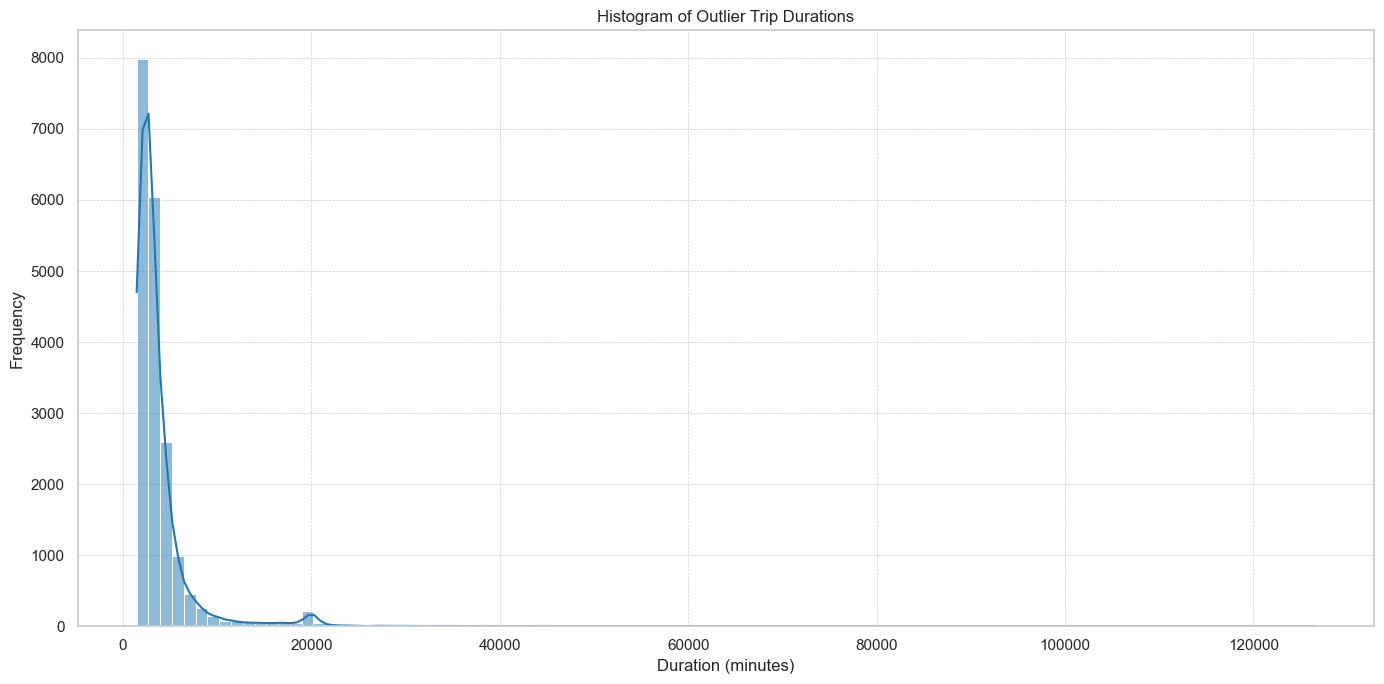

In [12]:
# Plotting a histogram for outlier trip durations
plt.figure(figsize=(14, 7))
sns.histplot(outlier_trips['TripDurationMin'], bins=100, kde=True)
plt.title('Histogram of Outlier Trip Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [13]:
# Calculate the number of days for each outlier trip
outlier_trips['Days'] = outlier_trips['TripDurationMin'] // 1440  # There are 1440 minutes in a day

# Count the number of trips for each day span
days_distribution = outlier_trips['Days'].value_counts().sort_index()

days_distribution


C:\Users\mihai\AppData\Local\Temp\ipykernel_21340\3353563448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_trips['Days'] = outlier_trips['TripDurationMin'] // 1440  # There are 1440 minutes in a day


Days
1.0     11225
2.0      4409
3.0      1639
4.0       631
5.0       353
6.0       171
7.0       106
8.0        66
9.0        60
10.0       51
11.0       50
12.0       52
13.0      190
14.0       69
15.0       14
16.0       10
17.0        3
18.0        6
19.0        3
20.0        4
21.0        3
22.0        3
23.0        2
24.0        3
25.0        2
26.0        3
28.0        1
29.0        2
30.0        4
31.0        2
33.0        2
36.0        1
37.0        1
38.0        1
41.0        2
42.0        2
44.0        1
45.0        1
46.0        3
49.0        1
50.0        1
57.0        1
58.0        1
61.0        2
62.0        1
63.0        1
64.0        1
65.0        1
76.0        1
84.0        1
87.0        2
Name: count, dtype: int64

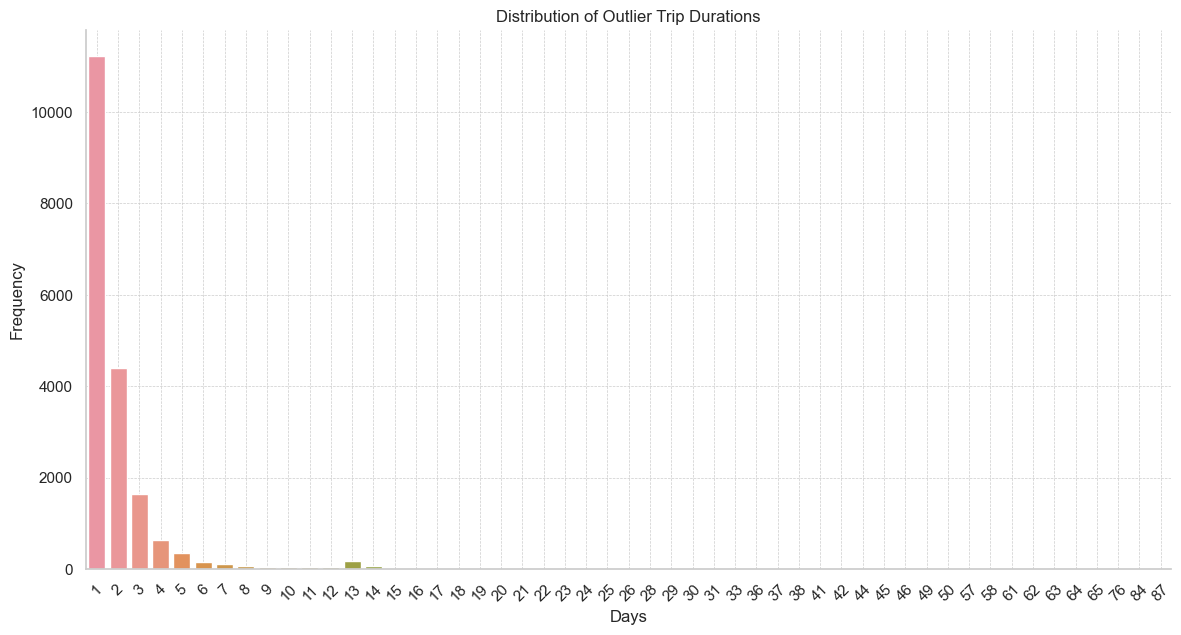

In [14]:
# plot the days_distribution
plt.figure(figsize=(14, 7))
sns.barplot(x=days_distribution.index.astype(np.int64), y=days_distribution.values)
plt.title('Distribution of Outlier Trip Durations')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
sns.despine()
plt.show()


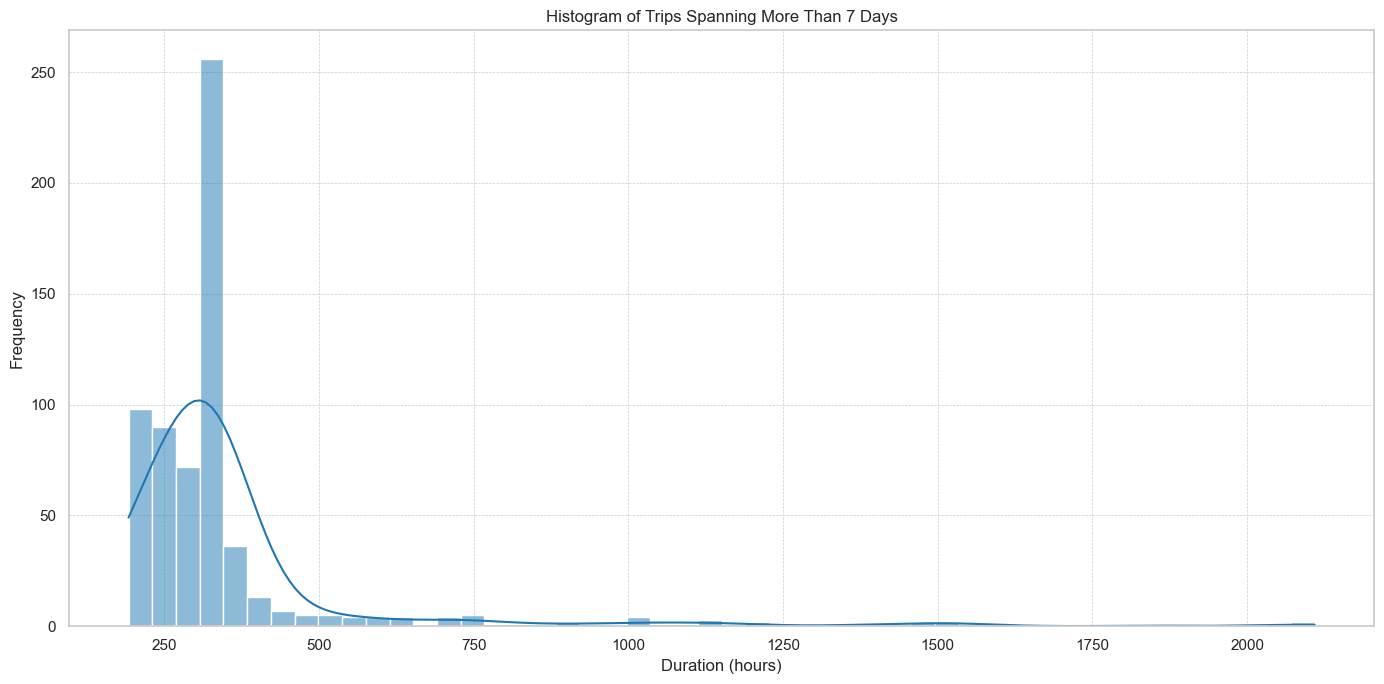

In [15]:
# Filter trips that span more than 7 days
long_duration_trips = outlier_trips[outlier_trips['Days'] > 7]

# Plotting a histogram for these long-duration trips
plt.figure(figsize=(14, 7))
sns.histplot(long_duration_trips['TripDurationHr'], bins=50, kde=True)
plt.title('Histogram of Trips Spanning More Than 7 Days')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [16]:
len(long_duration_trips)

631

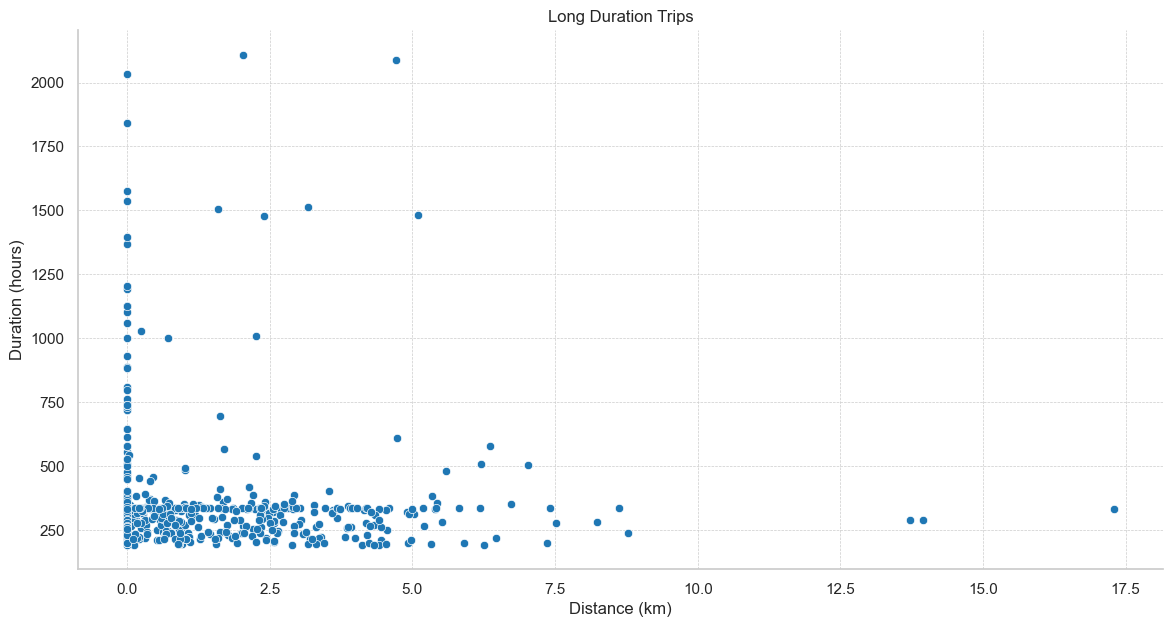

In [17]:
# scatter plot of the long duration in hours vs. the haversine distance
plt.figure(figsize=(14, 7))
sns.scatterplot(x=long_duration_trips['HaversineDistance'], y=long_duration_trips['TripDurationHr'])
plt.title('Long Duration Trips')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (hours)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()
plt.show()

In [18]:
# print the row of the top 10 longest trips
outlier_trips.sort_values('TripDurationMin', ascending=False).head(10)


,StartTime,EndTime,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd,StartHubClusterId,EndHubClusterId,StartClusterName,EndClusterName,StartClusterLatitude,StartClusterLongitude,EndClusterLatitude,EndClusterLongitude,HaversineDistance,Month,StartHour,Weekday,TripDurationMin,TripDurationHr,SpeedKmHr,Days
60462,2018-05-19 11:02:20.807840,2018-08-15 08:17:20.062634,144681,55.669027,12.579419,Ved Langebro,55.658239,12.605434,Skotlands Plads,539,331,Weidekampsgade / Thorshavnsgade,Skotlands Plads,55.668490,12.579917,55.658397,12.605787,2.025133,May,11,Saturday,126554.987580,2109.249793,0.001470,87.0
60463,2018-05-20 08:12:31.631738,2018-08-15 08:17:50.286699,14336,55.667553,12.553189,Litauens Plads,55.709616,12.561689,Sejrøgade,556,185,Litauens Plads,Sejrøgade,55.667035,12.552733,55.709616,12.561689,4.707382,May,8,Sunday,125285.310916,2088.088515,0.001485,87.0
26751,2018-04-21 16:35:03.195582,2018-07-15 11:16:49.206618,128376,55.704832,12.537932,Lygten,55.704832,12.537932,Lygten,295,295,Lygten,Lygten,55.704832,12.537932,55.704832,12.537932,0.000000,April,16,Saturday,122081.766851,2034.696114,0.001524,84.0
176889,2018-10-22 17:31:23.553629,2019-01-07 13:08:53.611385,267762,55.662698,12.563152,Havnebadet Fisketorvet,55.662698,12.563152,Havnebadet Fisketorvet,548,548,Cykelslangen,Cykelslangen,55.662797,12.562187,55.662798,12.562180,0.000000,October,17,Monday,110617.500963,1843.625016,0.001681,76.0
210794,2018-11-02 20:01:57.172792,2019-01-07 13:07:42.627135,303464,55.645486,12.522782,Valbyparken,55.645486,12.522782,Valbyparken,487,487,Valbyparken,Valbyparken,55.645486,12.522782,55.645486,12.522782,0.000000,November,20,Friday,94625.757572,1577.095960,0.001966,65.0
191763,2018-11-04 12:01:46.816979,2019-01-07 13:06:47.781957,304824,55.677285,12.577430,Gammel Strand,55.677285,12.577430,Gammel Strand,23,23,Badstuestræde,Badstuestræde,55.677501,12.576727,55.677501,12.576741,0.000000,November,12,Sunday,92225.016083,1537.083601,0.002017,64.0
116801,2018-07-14 20:39:10.951053,2018-09-15 22:29:51.716007,197543,55.693762,12.541943,Nørrebroparken,55.670371,12.570705,Politigården,233,581,Jægersborggade,Politigården,55.693333,12.542471,55.670370,12.570705,3.164771,July,20,Saturday,90830.679416,1513.844657,0.002048,63.0
73170,2018-06-06 15:55:44.900122,2018-08-08 10:06:30.816852,146042,55.672581,12.573892,Ny Carlsberg Glyptotek,55.677731,12.597614,3-Way Bridge,578,87,Ny Carlsberg Glyptotek,3-Way Bridge,55.672387,12.573684,55.677543,12.597042,1.593844,June,15,Wednesday,90370.765279,1506.179421,0.002058,62.0
190254,2018-10-27 14:27:19.846342,2018-12-28 09:54:13.154223,224781,55.659138,12.519597,Trekronergade,55.703422,12.541014,Mimersparken,444,296,Trekronergade,Mimersparken,55.659138,12.519597,55.703422,12.541014,5.103897,October,14,Saturday,89006.888465,1483.448141,0.002090,61.0
40564,2018-04-21 16:35:03.220640,2018-06-22 08:30:52.983862,128380,55.704832,12.537932,Lygten,55.685091,12.553199,Åboulevard,295,209,Lygten,Åboulevard,55.704832,12.537932,55.685012,12.553177,2.394533,April,16,Saturday,88795.829387,1479.930490,0.002095,61.0


In [19]:
# Calculate the number of trips lasting more than 2 weeks (14 days)
two_weeks_minutes = 14 * 24 * 60
long_trips_count = len(rentals[rentals['TripDurationMin'] > two_weeks_minutes])

# Calculate the percentage of these trips compared to the entire dataset
percentage_long_trips = (long_trips_count / len(rentals)) * 100

long_trips_count, percentage_long_trips


(162, 0.0634753954477954)

In [20]:
# create boolean column called RoundTrip
rentals['RoundTrip'] = rentals['StartHubClusterId'] == rentals['EndHubClusterId']


In [21]:
rentals.head()

,StartTime,EndTime,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd,StartHubClusterId,EndHubClusterId,StartClusterName,EndClusterName,StartClusterLatitude,StartClusterLongitude,EndClusterLatitude,EndClusterLongitude,HaversineDistance,Month,StartHour,Weekday,TripDurationMin,TripDurationHr,SpeedKmHr,RoundTrip
0,2018-03-01 17:43:14.707445,2018-03-01 18:14:12.145,108186,55.673440,12.564409,Central Station,55.658239,12.605434,Skotlands Plads,590,331,Central Station,Skotlands Plads,55.673117,12.564212,55.658397,12.605787,3.078446,March,17,Thursday,30.957293,0.515955,6.008277,False
1,2018-03-02 09:55:18.823405,2018-03-02 16:56:35.013,113852,55.687996,12.561522,Ravnsborg,55.687996,12.561522,Ravnsborg,193,193,Dronning Louises Bro,Dronning Louises Bro,55.687272,12.562037,55.687272,12.562039,0.000000,March,9,Friday,421.269827,7.021164,0.441522,True
2,2018-03-02 14:00:10.755516,2018-03-02 17:13:08.047,113912,55.682558,12.580462,Møntergade,55.682558,12.580462,Møntergade,33,33,Møntergade,Møntergade,55.682533,12.579492,55.682535,12.579493,0.000000,March,14,Friday,192.954858,3.215914,0.963956,True
3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544,113822,55.670289,12.565058,København H - Bus Stops,55.670289,12.565058,København H - Bus Stops,572,572,Tietgensgade,Tietgensgade,55.670060,12.564139,55.670053,12.564123,0.000000,March,10,Thursday,2038.201901,33.970032,0.091257,True
4,2018-03-02 08:51:47.459257,2018-03-02 21:18:48.813,113881,55.680517,12.587455,Nyhavn,55.668475,12.557384,Høkerboderne,77,575,Nyhavn,Høkerboderne,55.680611,12.587585,55.668317,12.557507,2.312564,March,8,Friday,747.022562,12.450376,0.248988,False


In [22]:
rentals.RoundTrip.value_counts(normalize=True)

RoundTrip
False    0.740891
True     0.259109
Name: proportion, dtype: float64

In [23]:
# calculate nr and percentage of trips longer than 2, 6, 12, 24 hours
# use TripDurationHr column
trip_durations = [3, 9, 16, 24]
trip_counts = []
trip_percentages = []

for duration in trip_durations:
    trips = rentals[rentals['TripDurationHr'] < duration]
    trip_count = len(trips)
    trip_percentage = (trip_count / len(rentals)) * 100
    trip_counts.append(trip_count)
    trip_percentages.append(trip_percentage)
    print(f"Number of trips shorter than {duration} hours: {trip_count}, Percentage: {trip_percentage:.2f}%")



Number of trips shorter than 3 hours: 120387, Percentage: 47.17%
Number of trips shorter than 9 hours: 182758, Percentage: 71.61%
Number of trips shorter than 16 hours: 219922, Percentage: 86.17%
Number of trips shorter than 24 hours: 235814, Percentage: 92.40%


In [24]:
# Drop trips lasting more than 2 weeks
rentals= rentals[rentals['TripDurationMin'] <= two_weeks_minutes]

# Confirm the removal
remaining_long_trips_count = len(rentals[rentals['TripDurationMin'] > two_weeks_minutes])
remaining_long_trips_count


0

# Trips less than 12h


In [25]:
# drop trips lasting more than 12 hours
rentals = rentals[rentals['TripDurationHr'] <= 12]

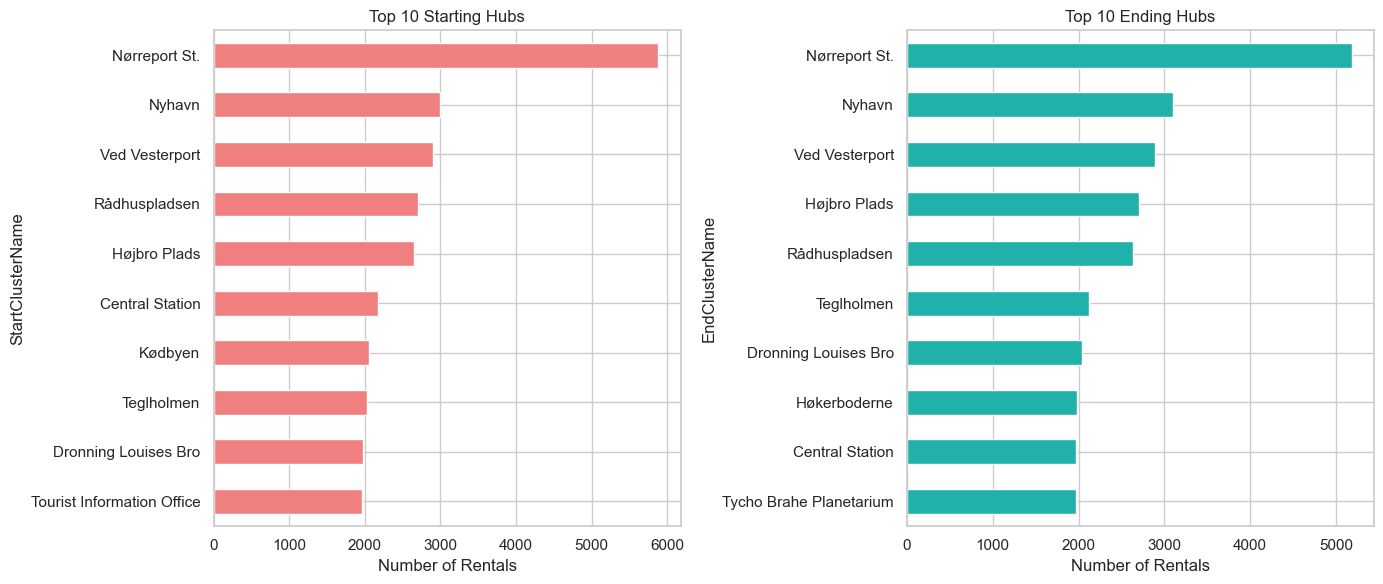

In [26]:
# Top 10 hubs for starting rentals
top_start_hubs = rentals['StartClusterName'].value_counts().head(10)

# Top 10 hubs for ending rentals
top_end_hubs = rentals['EndClusterName'].value_counts().head(10)

plt.figure(figsize=(14, 6))

# Plotting top starting hubs
plt.subplot(1, 2, 1)
top_start_hubs.plot(kind='barh', color='lightcoral')
plt.title('Top 10 Starting Hubs')
plt.xlabel('Number of Rentals')
plt.gca().invert_yaxis()  # To have the hub with the highest count at the top

# Plotting top ending hubs
plt.subplot(1, 2, 2)
top_end_hubs.plot(kind='barh', color='lightseagreen')
plt.title('Top 10 Ending Hubs')
plt.xlabel('Number of Rentals')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


c:\ProgramData\anaconda3\envs\thesis\Lib\site-packages\seaborn\_oldcore.py:1599: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


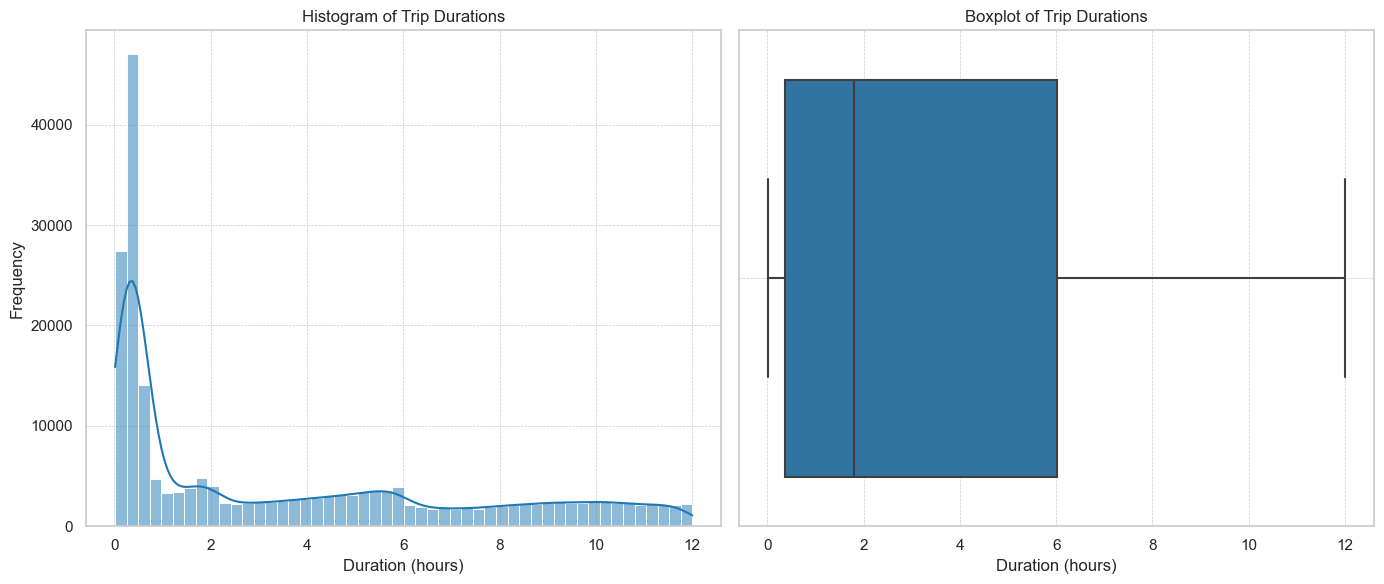

In [27]:
# plot the distribution of the TripDurationHr column using a histogram and a boxplot using subplots

plt.figure(figsize=(14, 6))

# Plotting a histogram
plt.subplot(1, 2, 1)
sns.histplot(rentals['TripDurationHr'], bins=50, kde=True)
plt.title('Histogram of Trip Durations')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plotting a boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=rentals['TripDurationHr'], orient='v')
plt.title('Boxplot of Trip Durations')
plt.xlabel('Duration (hours)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()




In [28]:
# Create a combined column representing the route as "StartHub -> EndHub"
rentals['Route'] = rentals['StartClusterName'] + " -> " + rentals['EndClusterName']

# Identify the top 10 most popular routes
top_routes = rentals['Route'].value_counts().head(20)

top_routes


Route
Nørreport St. -> Nørreport St.                              1180
Ved Vesterport -> Ved Vesterport                            1015
Central Station -> Central Station                           837
Teglholmen -> Teglholmen                                     793
Tycho Brahe Planetarium -> Tycho Brahe Planetarium           652
Rådhuspladsen -> Rådhuspladsen                               526
Vandkunsten -> Vandkunsten                                   521
Sankt Hans Torv -> Sankt Hans Torv                           485
Jarmers Plads -> Jarmers Plads                               467
Vesterbrogade / Saxogade -> Vesterbrogade / Saxogade         458
Nyhavn -> Nyhavn                                             458
Palace Teatre -> Palace Teatre                               450
Elbagade -> Elbagade                                         436
Overgaden Neden Vandet -> Overgaden Neden Vandet             432
Tourist Information Office -> Tourist Information Office     429
Bryghusgade -> Bryg

In [29]:
# for each value in top_routes, get the average trip duration
avg_durations = []
for route in top_routes:
    avg_duration = rentals[rentals['Route'] == route]['TripDurationHr'].mean()
    avg_durations.append(avg_duration)

In [30]:
# for each top route, calculate the average trip duration
longest_routes_duration = rentals.groupby('Route').aggregate({'TripDurationHr': 'mean'}).sort_values('TripDurationHr', ascending=False).head(20)

In [31]:
longest_routes_duration

,TripDurationHr
Route,
Kampmannsgade -> Gammeltorv,11.996484
Henrik Ibsens Vej -> Hjørringgade,11.996298
Nørre Farimagsgade -> Frederikssundsvej,11.992636
Landsdommervej -> Lundtoftegade,11.991496
Tourist Information Office -> Masnedøgade,11.990119
Bernstorffsgade -> Frederikssundsvej,11.989973
Strandlodsvej -> Laplandsgade North,11.989370
Den Sorte Plads -> Rainmaking Loft,11.989346
Skoleholdervej -> Charlottenlund St. Ii,11.988711


In [32]:
rentals.StartHour.value_counts().sort_index()

StartHour
0      1945
1      1503
2      1092
3       840
4      1315
5      3986
6     10786
7     15664
8     16941
9     18855
10    17370
11    14182
12    12457
13    12006
14    13218
15    14654
16    12884
17     9907
18     7720
19     6781
20     5624
21     4855
22     3757
23     2942
Name: count, dtype: int64

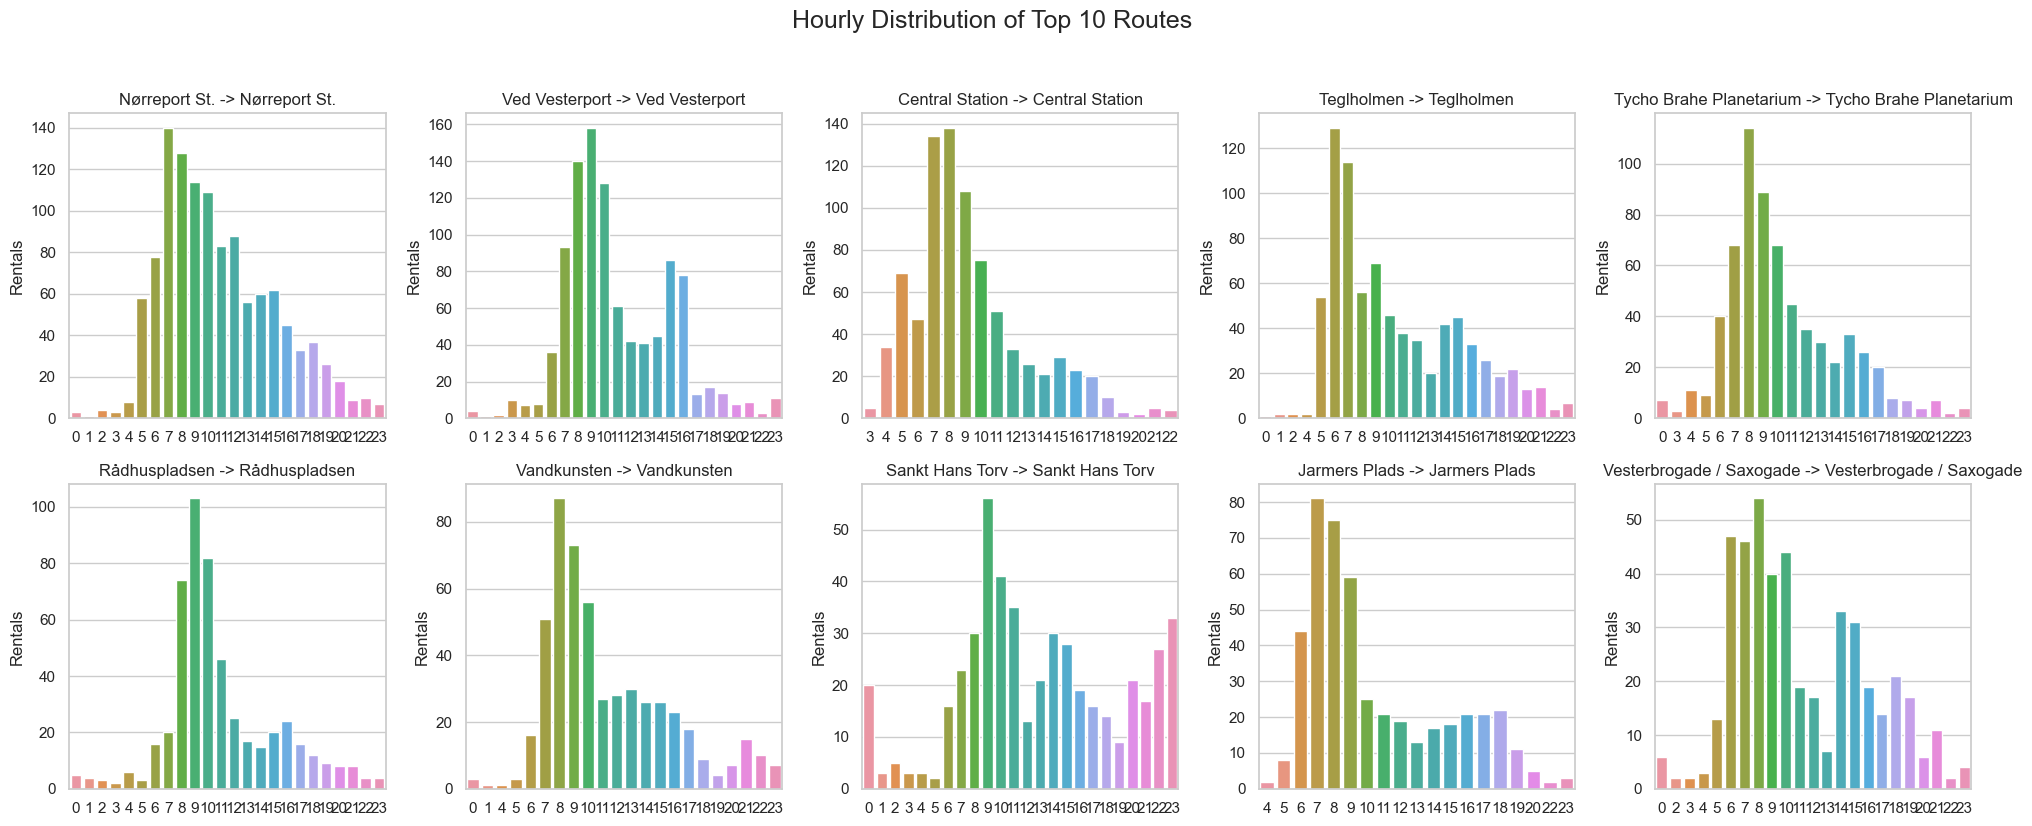

In [33]:
# Create a list of the top 10 most popular routes
top_routes = rentals['Route'].value_counts().head(10).index
top_routes_series = rentals['Route'].value_counts().head(10)

# Create a figure with 5 columns and 2 rows
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Flatten the axes array
axes = axes.flatten()

# Loop through the top 10 routes and create a countplot for each one
for i, route in enumerate(top_routes):
    route_rentals = rentals[rentals['Route'] == route]
    sns.countplot(x='StartHour', data=route_rentals, ax=axes[i])
    axes[i].set_title(route)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Rentals')

plt.suptitle('Hourly Distribution of Top 10 Routes', y=1.03, fontsize=18)
plt.tight_layout()
plt.show()


In [34]:
top_routes_series

Route
Nørreport St. -> Nørreport St.                          1180
Ved Vesterport -> Ved Vesterport                        1015
Central Station -> Central Station                       837
Teglholmen -> Teglholmen                                 793
Tycho Brahe Planetarium -> Tycho Brahe Planetarium       652
Rådhuspladsen -> Rådhuspladsen                           526
Vandkunsten -> Vandkunsten                               521
Sankt Hans Torv -> Sankt Hans Torv                       485
Jarmers Plads -> Jarmers Plads                           467
Vesterbrogade / Saxogade -> Vesterbrogade / Saxogade     458
Name: count, dtype: int64

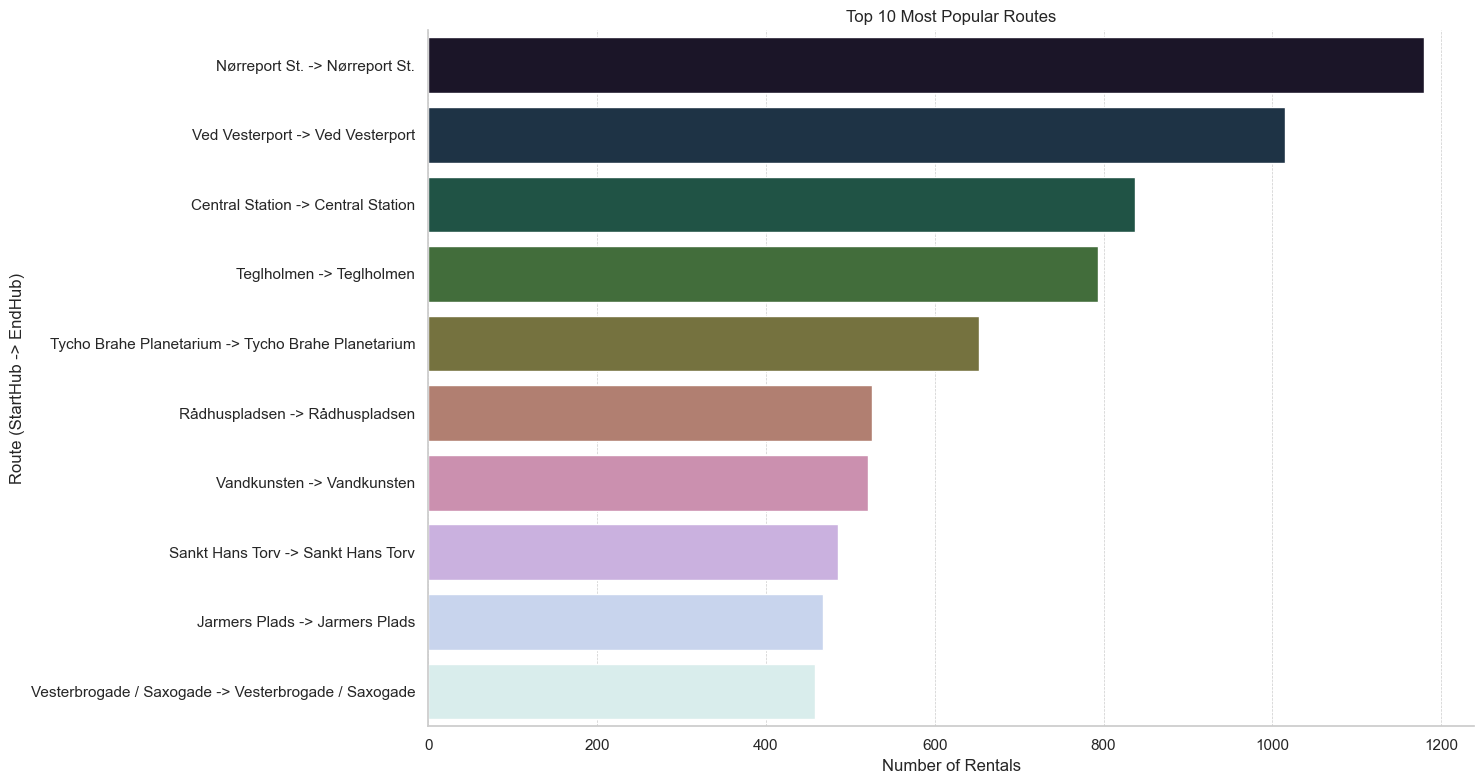

In [35]:
# Plotting the top 10 most popular routes
plt.figure(figsize=(15, 8))
top_routes_plot = sns.barplot(y=top_routes_series.index, x=top_routes_series.values, palette='cubehelix')
plt.title('Top 10 Most Popular Routes')
plt.xlabel('Number of Rentals')
plt.ylabel('Route (StartHub -> EndHub)')
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
sns.despine()
plt.show()


In [36]:
top_routes

Index(['Nørreport St. -> Nørreport St.', 'Ved Vesterport -> Ved Vesterport',
       'Central Station -> Central Station', 'Teglholmen -> Teglholmen',
       'Tycho Brahe Planetarium -> Tycho Brahe Planetarium',
       'Rådhuspladsen -> Rådhuspladsen', 'Vandkunsten -> Vandkunsten',
       'Sankt Hans Torv -> Sankt Hans Torv', 'Jarmers Plads -> Jarmers Plads',
       'Vesterbrogade / Saxogade -> Vesterbrogade / Saxogade'],
      dtype='object', name='Route')

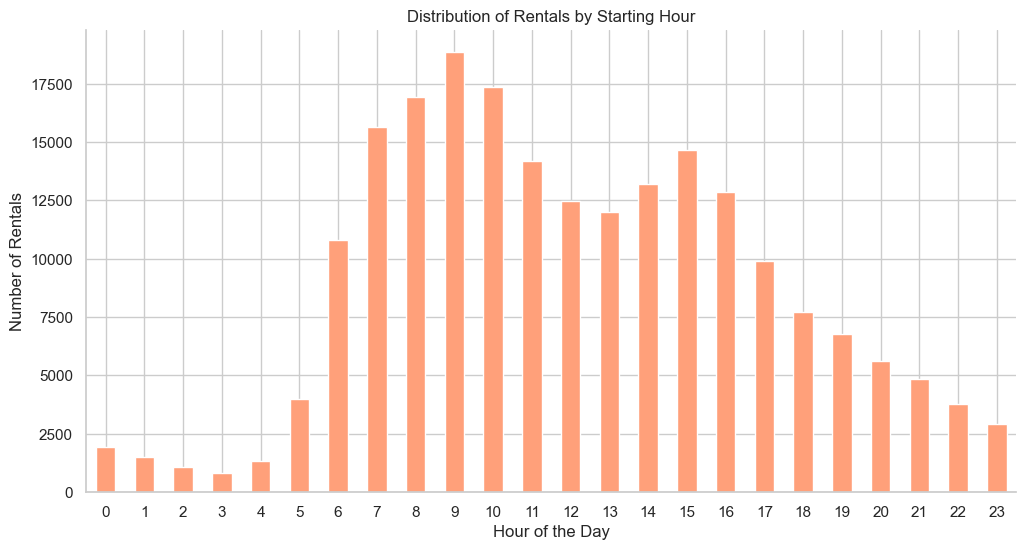

In [37]:
# Distribution of rentals based on starting hour
hourly_rentals = rentals.groupby('StartHour').size()

plt.figure(figsize=(12, 6))
hourly_rentals.plot(kind='bar', color='lightsalmon')
plt.title('Distribution of Rentals by Starting Hour')
plt.ylabel('Number of Rentals')
plt.xlabel('Hour of the Day')
plt.xticks(rotation=0)
sns.despine()
plt.show()


## Hourly Distribution of Rentals

The bar chart showcases the hourly distribution of rentals:

- **Morning Peak:** There is a noticeable peak around 8-9 AM, which corresponds to typical morning commute times.
- **Afternoon-Early Evening Peak:** Another significant peak is observed between 4-6 PM, aligning with evening commute times.
- **Off-Peak Hours:** The early hours (midnight to 5 AM) see the least activity, which is expected as these are typically non-commute and resting hours.
- **Steady Usage:** Throughout the day, there's steady usage of rentals, with a slight dip in the early afternoon.

These patterns align with what we might expect for a public transport system, where users rent bikes for commuting to work or other daily activities.

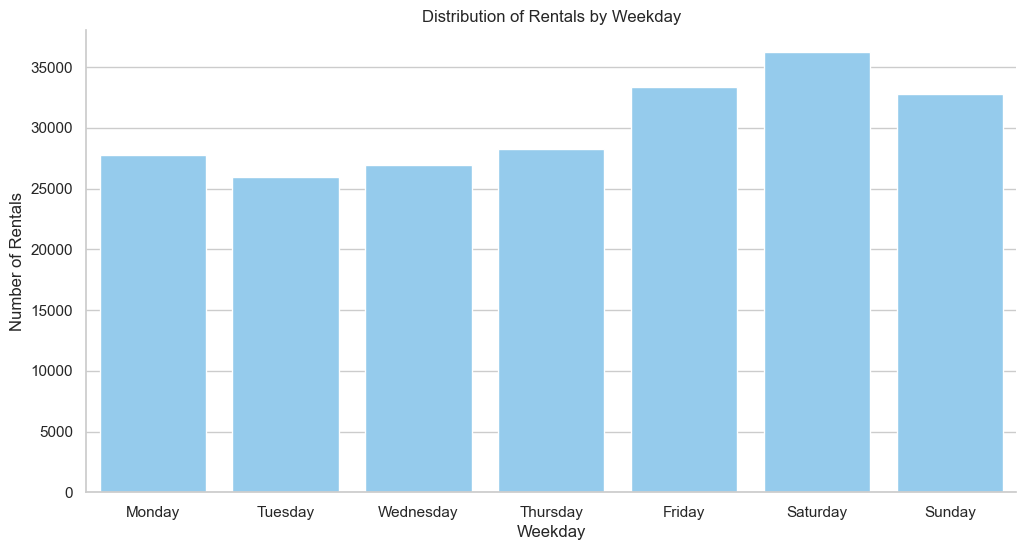

In [38]:
plt.figure(figsize=(12, 6))
sns.countplot(data = rentals, x = 'Weekday', color='lightskyblue', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Distribution of Rentals by Weekday')
plt.ylabel('Number of Rentals')
plt.xlabel('Weekday')
plt.xticks(rotation=0)
sns.despine()
plt.show()

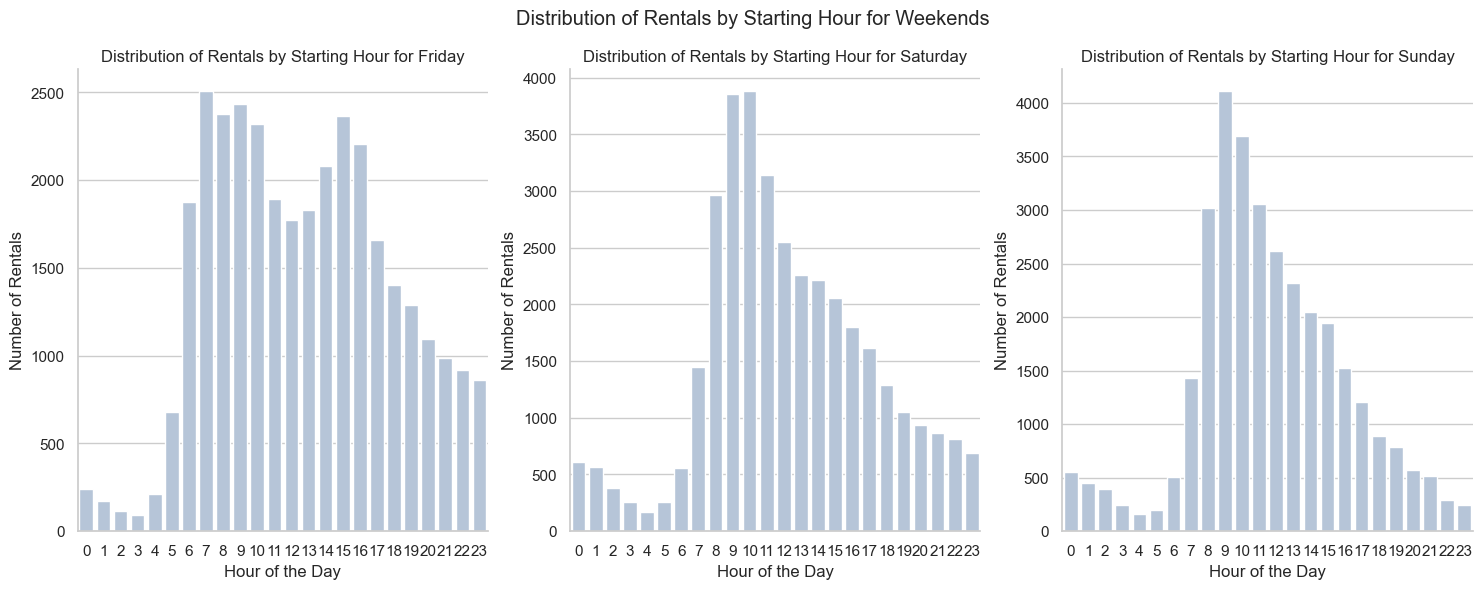

In [39]:
# for Friday, Saturday, and Sunday explore the hourly distribution
weekend_rentals = rentals[rentals['Weekday'].isin(['Friday', 'Saturday', 'Sunday'])]

weekenddays = ['Friday', 'Saturday', 'Sunday']
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, day in enumerate(weekenddays):
    day_rentals = weekend_rentals[weekend_rentals['Weekday'] == day]
    sns.countplot(data=day_rentals, x='StartHour', color='lightsteelblue', ax=axs[i])
    axs[i].set_title(f'Distribution of Rentals by Starting Hour for {day}')
    axs[i].set_ylabel('Number of Rentals')
    axs[i].set_xlabel('Hour of the Day')
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0)
    sns.despine()

plt.suptitle('Distribution of Rentals by Starting Hour for Weekends')
plt.show()


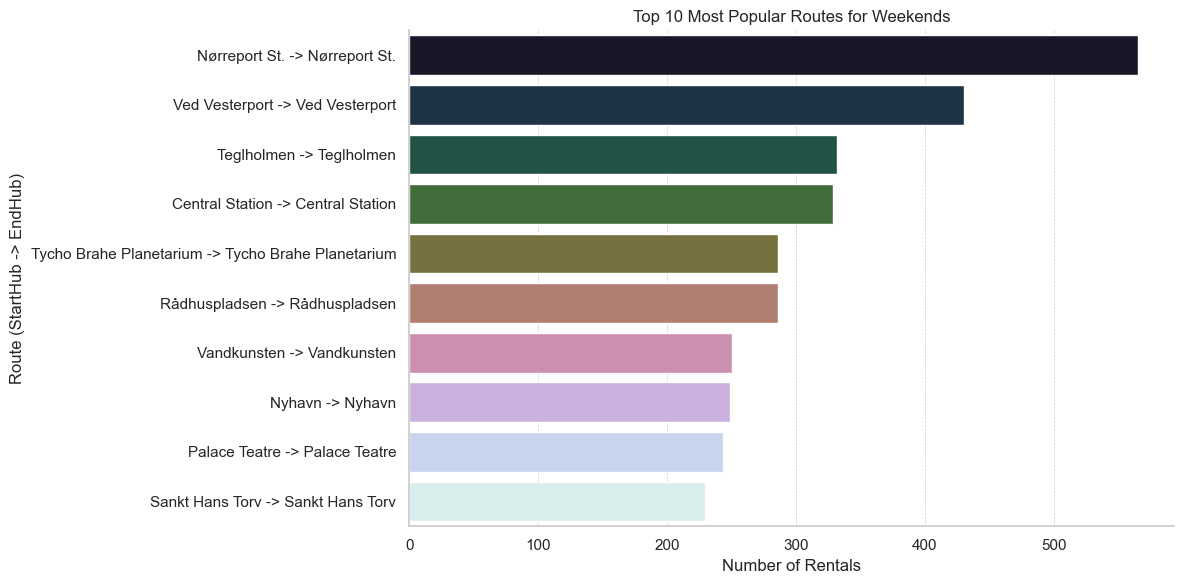

In [40]:
# PLOT THE 10 TOP ROUTES in the weekend 
# Create a list of the top 10 most popular routes
weekend_top_routes = weekend_rentals['Route'].value_counts().head(10).index
weekend_top_routes_series = weekend_rentals['Route'].value_counts().head(10)

# plot the count of each top route
plt.figure(figsize=(12, 6))
weekend_top_routes_plot = sns.barplot(y=weekend_top_routes_series.index, x=weekend_top_routes_series.values, palette='cubehelix')   
plt.title('Top 10 Most Popular Routes for Weekends')
plt.xlabel('Number of Rentals')
plt.ylabel('Route (StartHub -> EndHub)')
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
sns.despine()
plt.show()

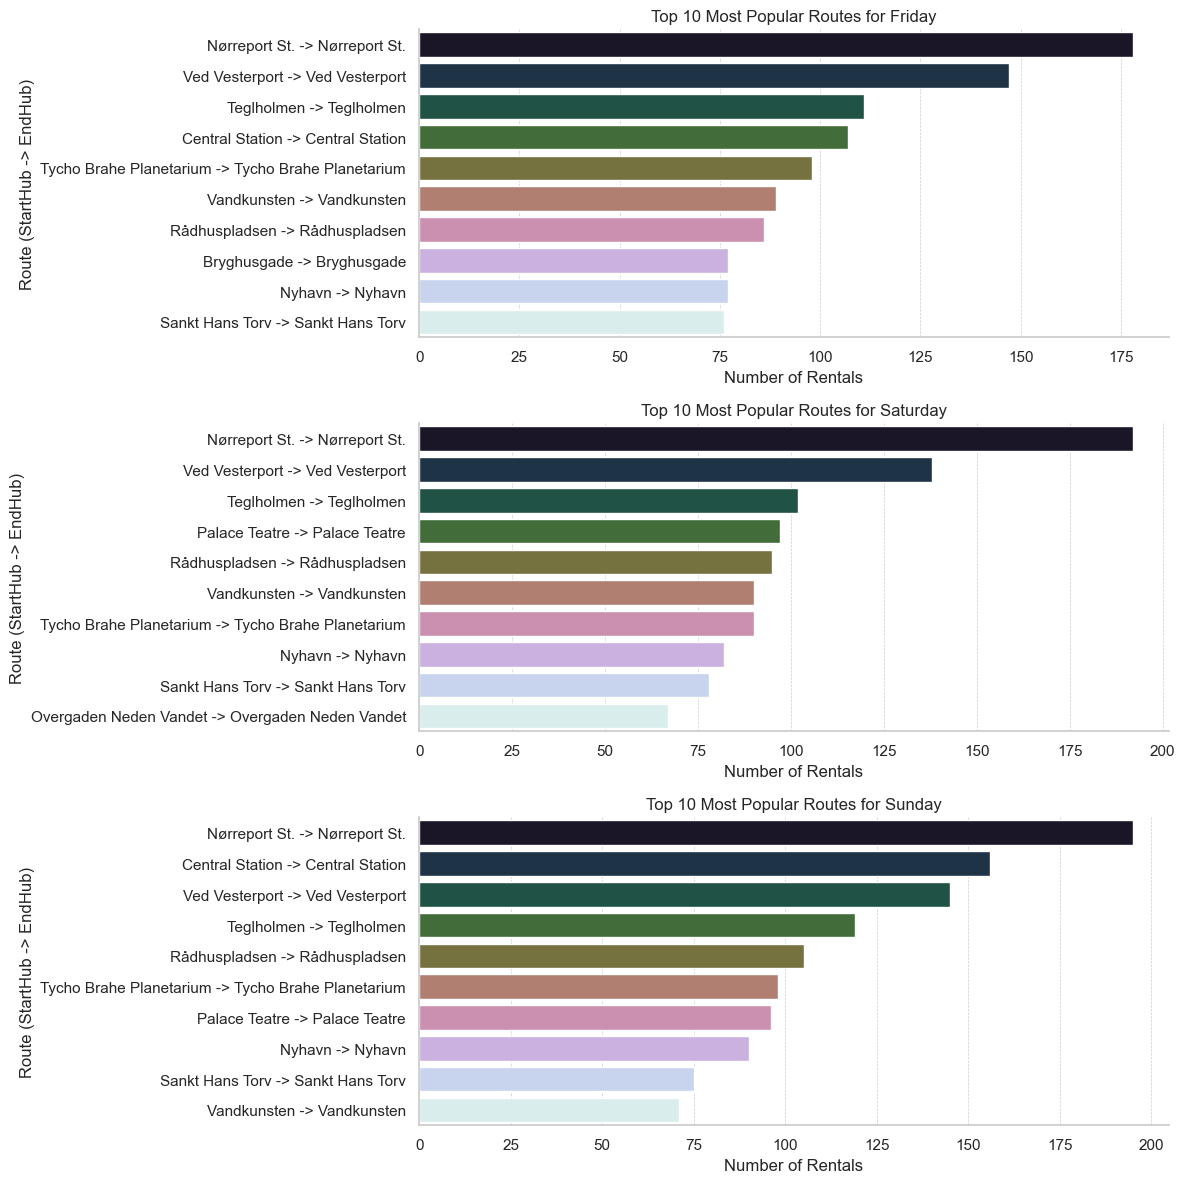

In [41]:
# Create a list of the top 10 most popular routes for each day of the weekend
weekend_top_routes = {}
for day in ['Friday', 'Saturday', 'Sunday']:
    weekend_top_routes[day] = rentals[rentals['Weekday'] == day]['Route'].value_counts().head(10)

# plot the count of each top route for each day of the weekend
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

for i, day in enumerate(['Friday', 'Saturday', 'Sunday']):
    sns.barplot(y=weekend_top_routes[day].index, x=weekend_top_routes[day].values, palette='cubehelix', ax=axs[i])
    axs[i].set_title(f'Top 10 Most Popular Routes for {day}')
    axs[i].set_xlabel('Number of Rentals')
    axs[i].set_ylabel('Route (StartHub -> EndHub)')
    axs[i].grid(axis='x', linestyle='--', linewidth=0.5)
    sns.despine()

# remove the last subplot
#fig.delaxes(axs[1, 1])
plt.tight_layout()

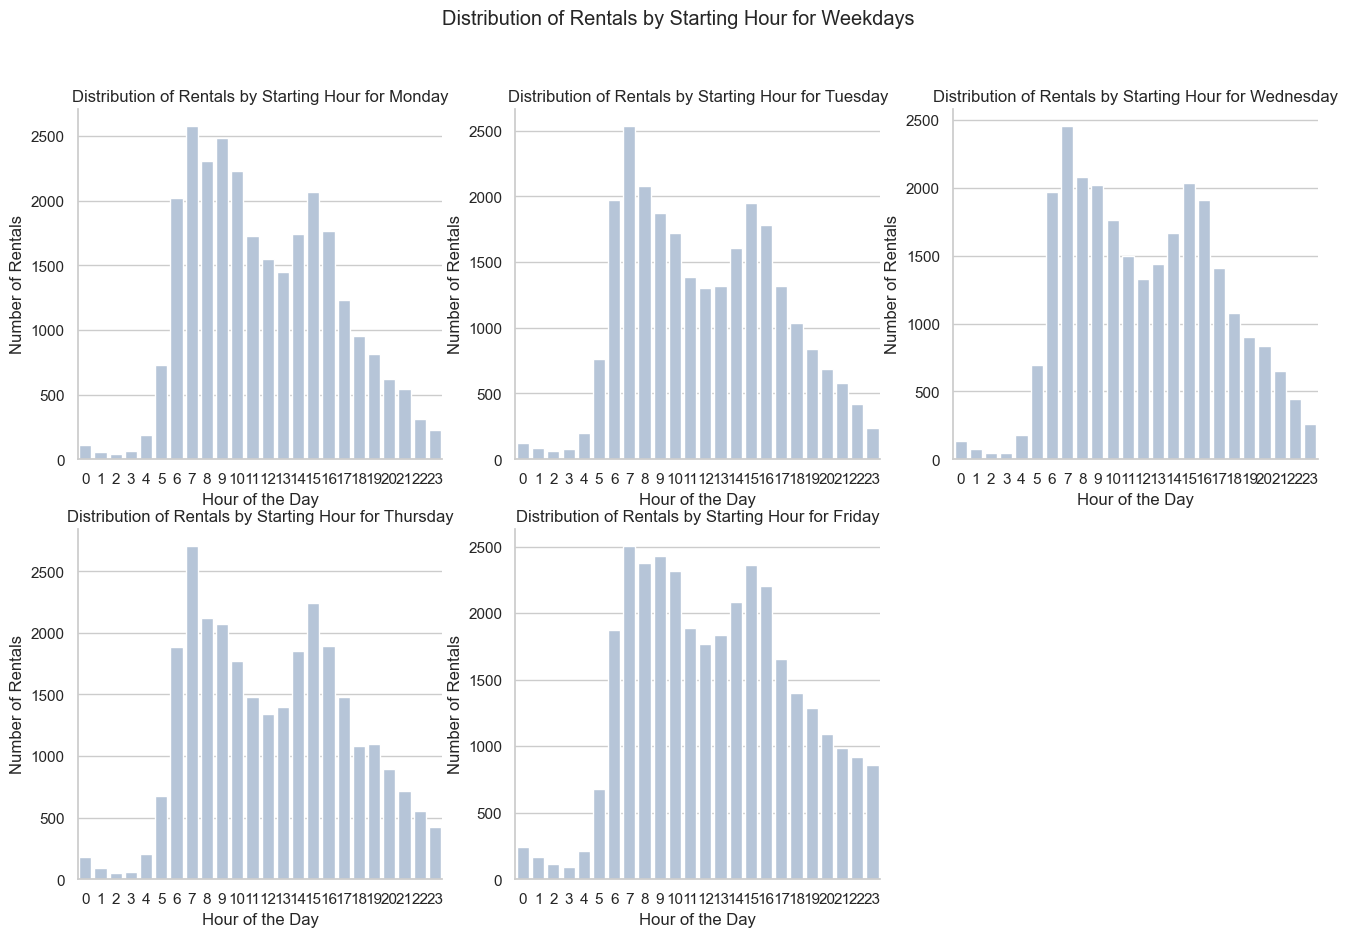

In [42]:
# for Monday to Friday, explore the hourly distribution
weekday_rentals = rentals[rentals['Weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, day in enumerate(weekdays):
    row = i // 3
    col = i % 3
    day_rentals = weekday_rentals[weekday_rentals['Weekday'] == day]
    sns.countplot(data=day_rentals, x='StartHour', color='lightsteelblue', ax=axs[row, col])
    axs[row, col].set_title(f'Distribution of Rentals by Starting Hour for {day}')
    axs[row, col].set_ylabel('Number of Rentals')
    axs[row, col].set_xlabel('Hour of the Day')
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=0)
    sns.despine()

plt.suptitle('Distribution of Rentals by Starting Hour for Weekdays')
# remove the last subplot
fig.delaxes(axs[1, 2])
plt.show()


In [43]:
# Group by StartTime date (ignoring the time component) and count the rentals
daily_rentals = rentals.groupby(rentals['StartTime'].dt.date).size()

# Plotly interactive plot for Rentals by Date
fig2 = px.line(daily_rentals.reset_index(), x='StartTime', y=0, 
               labels={'0': 'Number of Rentals', 'StartTime': 'Date'},
               title='Rentals by Date')
fig2.update_xaxes(rangeslider_visible=True, tickmode='linear', dtick='M1')
# set size
fig2.update_layout(width= 1000,height=600)

fig2.show()


In [44]:
# create a plotly line figure of number of rentals by month but keeping in mind the year as well
rentals['YearMonth'] = rentals['StartTime'].dt.strftime('%Y-%m')
monthly_rentals = rentals.groupby('YearMonth').size()   

fig3 = px.line(monthly_rentals.reset_index(), x='YearMonth', y=0,
                labels={'0': 'Number of Rentals', 'YearMonth': 'Month'},
                title='Rentals by Month', markers= 'lines+markers')
fig3.update_xaxes(rangeslider_visible=True, tickmode='linear', dtick='M1')
# set figure size
fig3.update_layout(width= 1000,height=600)
fig3.show()





In [45]:
rentals.columns

Index(['StartTime', 'EndTime', 'UserId', 'latitudeStart', 'longitudeStart',
       'nameStart', 'latitudeEnd', 'longitudeEnd', 'nameEnd',
       'StartHubClusterId', 'EndHubClusterId', 'StartClusterName',
       'EndClusterName', 'StartClusterLatitude', 'StartClusterLongitude',
       'EndClusterLatitude', 'EndClusterLongitude', 'HaversineDistance',
       'Month', 'StartHour', 'Weekday', 'TripDurationMin', 'TripDurationHr',
       'SpeedKmHr', 'RoundTrip', 'Route', 'YearMonth'],
      dtype='object')

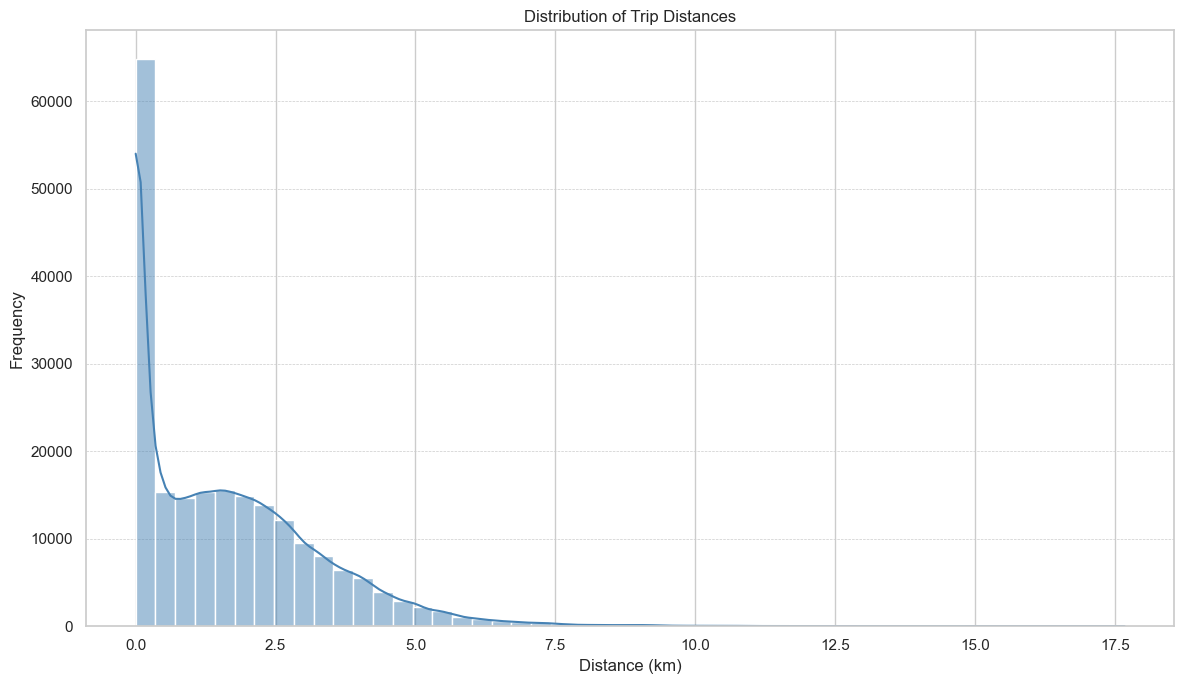

In [46]:
# Plotting the distribution of trip distances using a histogram
plt.figure(figsize=(12, 7))
sns.histplot(rentals['HaversineDistance'], bins=50, kde=True, color="steelblue")
plt.title('Distribution of Trip Distances')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Short Trips: A significant majority of the trips are short, with distances less than 5 km. This suggests that these rentals are primarily used for short commutes, which aligns with the idea of multimodality in public transport.

Peak around 0 km: There's a noticeable peak close to 0 km. This could indicate that many trips are short round trips, where users return to the starting hub, or it could be indicative of short trips between nearby hubs.

Longer Trips: There are a few trips that extend beyond 10 km, but they are relatively less frequent.

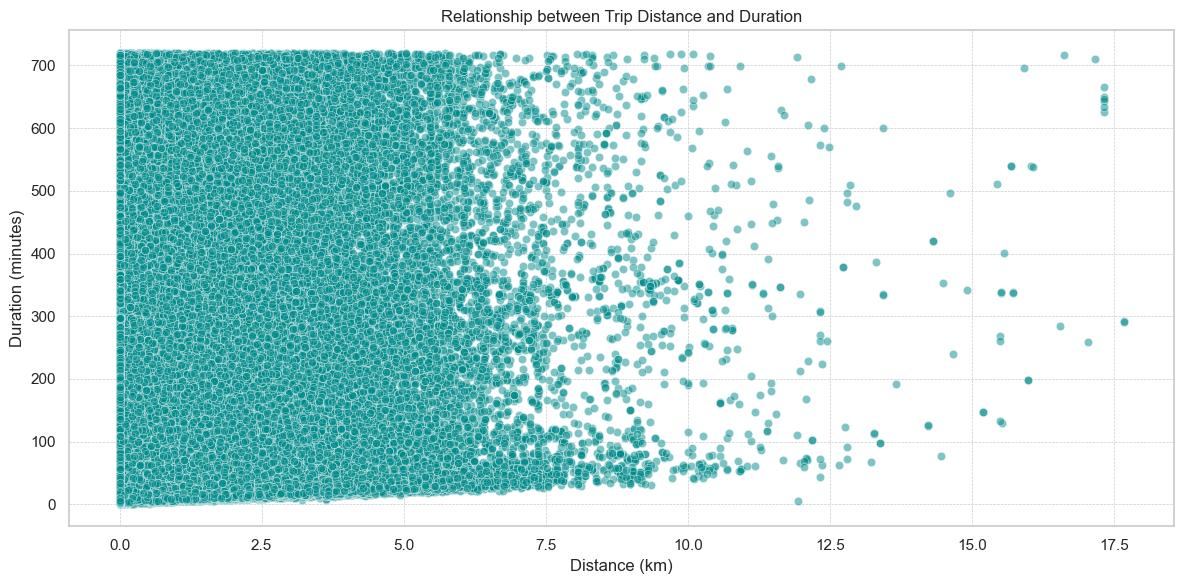

In [47]:
# Scatter plot to visualize the relationship between trip distance and duration
plt.figure(figsize=(12, 6))
sns.scatterplot(data=rentals, x='HaversineDistance', y='TripDurationMin', alpha=0.5, color="darkcyan")
plt.title('Relationship between Trip Distance and Duration')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (minutes)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Positive Correlation: As expected, there's a general trend indicating that as the trip distance increases, the duration also tends to increase.

Dense Cluster: There's a dense cluster of points in the bottom-left region, indicating many short trips with short durations. This aligns with our earlier observation that most trips are short and are likely used for quick commutes.

Variability: For a given distance, there's variability in trip duration, which could be influenced by factors like traffic, user speed preferences, stops, or detours.

In [48]:
# load cop_area dataset
cop_area = gpd.read_file('../data/processed/cop_area.shp')

In [49]:

# load an empty map
##map_1 = KeplerGl(height=600, width=800)
#map_1

In [50]:
# add data to Kepler map
# map_1.add_data(data=rentals, name='rentals')
# map_1.add_data(data=cop_area, name='cop_area')

In [51]:
rentals.columns

Index(['StartTime', 'EndTime', 'UserId', 'latitudeStart', 'longitudeStart',
       'nameStart', 'latitudeEnd', 'longitudeEnd', 'nameEnd',
       'StartHubClusterId', 'EndHubClusterId', 'StartClusterName',
       'EndClusterName', 'StartClusterLatitude', 'StartClusterLongitude',
       'EndClusterLatitude', 'EndClusterLongitude', 'HaversineDistance',
       'Month', 'StartHour', 'Weekday', 'TripDurationMin', 'TripDurationHr',
       'SpeedKmHr', 'RoundTrip', 'Route', 'YearMonth'],
      dtype='object')

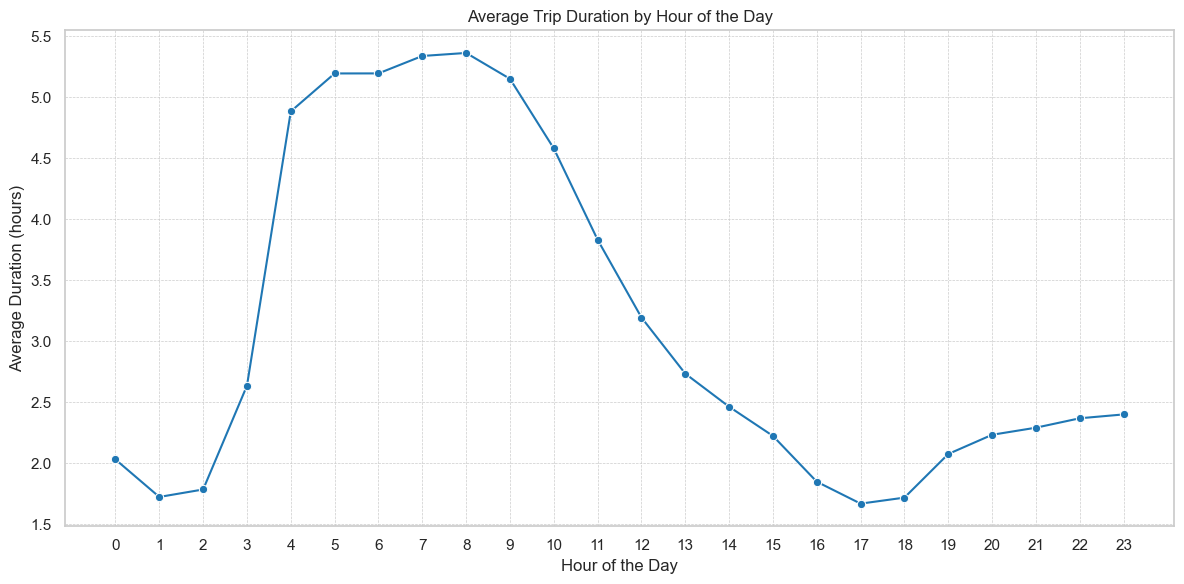

In [52]:
# Filter out trips longer than 12 hours
filtered_rentals = rentals[rentals['TripDurationHr'] <= 12]


# Group the data by StartHour and calculate the average trip duration for each hour
hourly_duration = filtered_rentals.groupby('StartHour')['TripDurationHr'].mean().reset_index()

# Plot the average trip duration by hour of the day
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_duration, x='StartHour', y='TripDurationHr', marker='o')
plt.title('Average Trip Duration by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Duration (hours)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


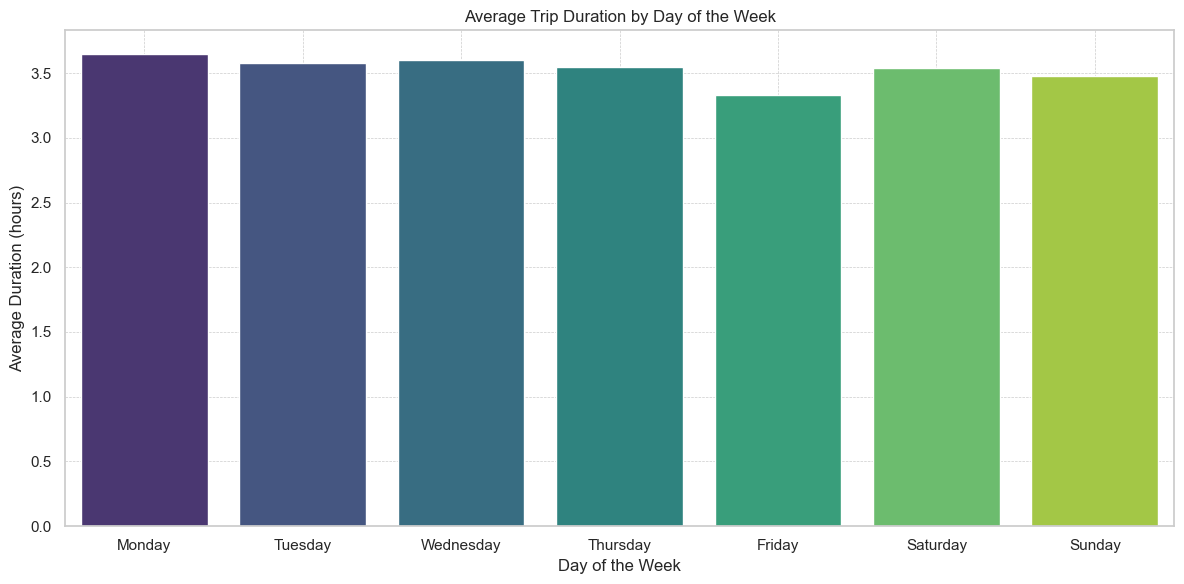

In [53]:
# Create a new column for the day of the week when the trip started
filtered_rentals['StartDayOfWeek'] = filtered_rentals['StartTime'].dt.day_name()

# Order the days of the week for plotting
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Group the data by StartDayOfWeek and calculate the average trip duration for each day
daily_duration = filtered_rentals.groupby('StartDayOfWeek')['TripDurationHr'].mean().reindex(days_order).reset_index()

# Plot the average trip duration by day of the week
plt.figure(figsize=(12, 6))
sns.barplot(data=daily_duration, x='StartDayOfWeek', y='TripDurationHr', palette='viridis')
plt.title('Average Trip Duration by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Duration (hours)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


The bar plot illustrates the average trip duration by day of the week. Here are some key observations:

The average trip duration is relatively consistent across weekdays (Monday to Friday), with a slight increase on Fridays.
There is a noticeable increase in the average trip duration during the weekend (Saturday and Sunday). This could suggest that longer trips are more prevalent on weekends, potentially due to leisure activities or recreational biking.
Implications for Grouping Strategy:
The longer trip durations on weekends suggest that leisure or recreational biking plays a significant role. This should be considered when defining the grouping thresholds, as it indicates that longer trips might not be solely for commuting purposes.
Revised Grouping Suggestion:
Based on the temporal analysis, here's a revised suggestion for grouping trip durations:

Short Trips: 0-1 hours (primarily short commutes or errands)
Medium Trips: 1-3 hours (possibly longer commutes, leisure trips, or errands involving multiple stops)
Long Trips: 3-6 hours (likely recreational or leisure trips, more common on weekends)
Extended Trips: 6-12 hours (special cases, perhaps day-long rentals or bikes kept for convenience)

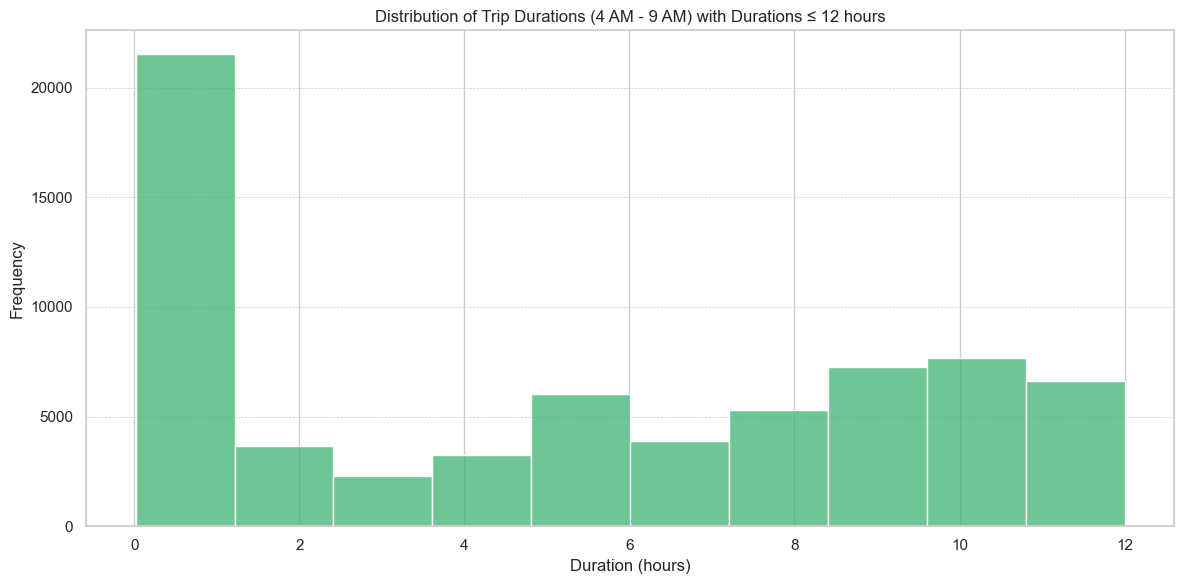

In [54]:
#create morning trips dataframe of trips between 4-9 am
morning_trips = rentals[(rentals['StartHour'] >= 4) & (rentals['StartHour'] <= 9)]
# Further filtering the data to only include trips with a duration less than or equal to 12 hours
morning_trips_filtered = morning_trips[morning_trips['TripDurationHr'] <= 12]

# Plotting a histogram for the TripDurationHr column for the filtered data
plt.figure(figsize=(12, 6))
sns.histplot(data=morning_trips_filtered, x='TripDurationHr', bins=10, color="mediumseagreen")
plt.title('Distribution of Trip Durations (4 AM - 9 AM) with Durations ≤ 12 hours')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


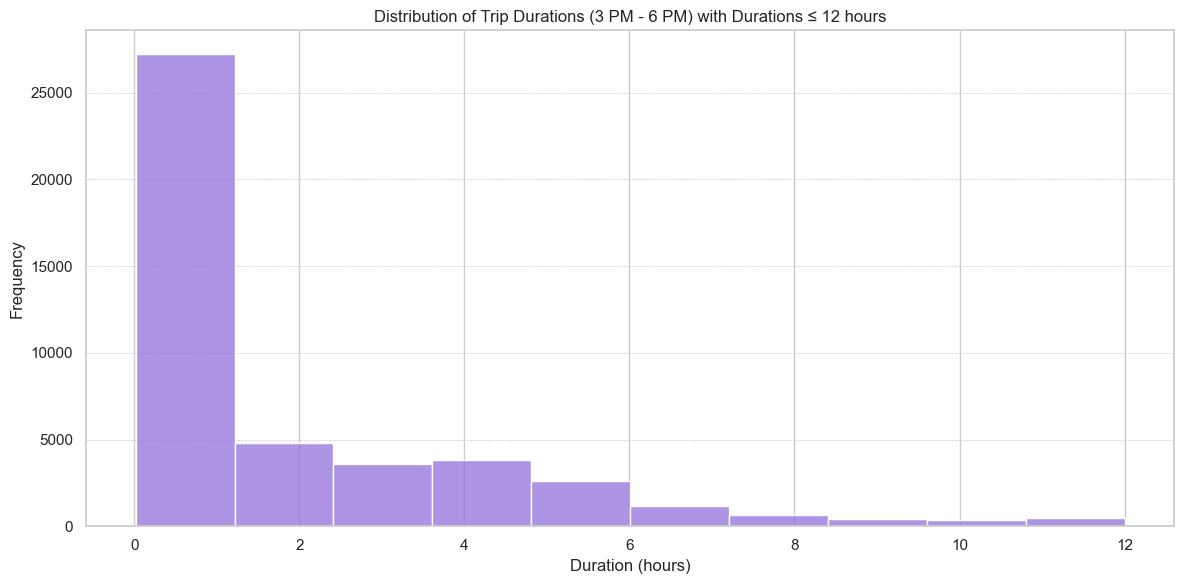

In [55]:
# Filtering the data again to limit the trip duration to 12 hours
afternoon_trips_filtered = rentals[(rentals['StartHour'] >= 15) & (rentals['StartHour'] <= 18) & (rentals['TripDurationHr'] <= 12)]

# Plotting a histogram for the TripDurationHr column with 10 bins
plt.figure(figsize=(12, 6))
sns.histplot(data=afternoon_trips_filtered, x='TripDurationHr', bins=10, color="mediumpurple")
plt.title('Distribution of Trip Durations (3 PM - 6 PM) with Durations ≤ 12 hours')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [56]:
# Creating the groups based on the TripDurationHr column
bins = [0, 1, 4, 8, 12]
labels = ['0-1 hour', '1-4 hours', '4-8 hours', '8-12 hours']
rentals['DurationGroup'] = pd.cut(rentals['TripDurationHr'], bins=bins, labels=labels, right=False, ordered=True)

# Displaying the first few rows of the dataset with the new 'DurationGroup' column
rentals[['TripDurationHr', 'DurationGroup']].head()


,TripDurationHr,DurationGroup
0,0.515955,0-1 hour
1,7.021164,4-8 hours
2,3.215914,1-4 hours
5,0.295072,0-1 hour
6,5.672666,4-8 hours


In [58]:
percentage_duration = rentals.groupby("DurationGroup")["RoundTrip"].mean() * 100
percentage_duration

DurationGroup
0-1 hour       7.537275
1-4 hours     29.138575
4-8 hours     37.757699
8-12 hours    45.964996
Name: RoundTrip, dtype: float64

Percentage of round trips for 0-1 hour: 7.54%
Percentage of round trips for 1-4 hours: 29.14%
Percentage of round trips for 4-8 hours: 37.76%
Percentage of round trips for 8-12 hours: 45.96%


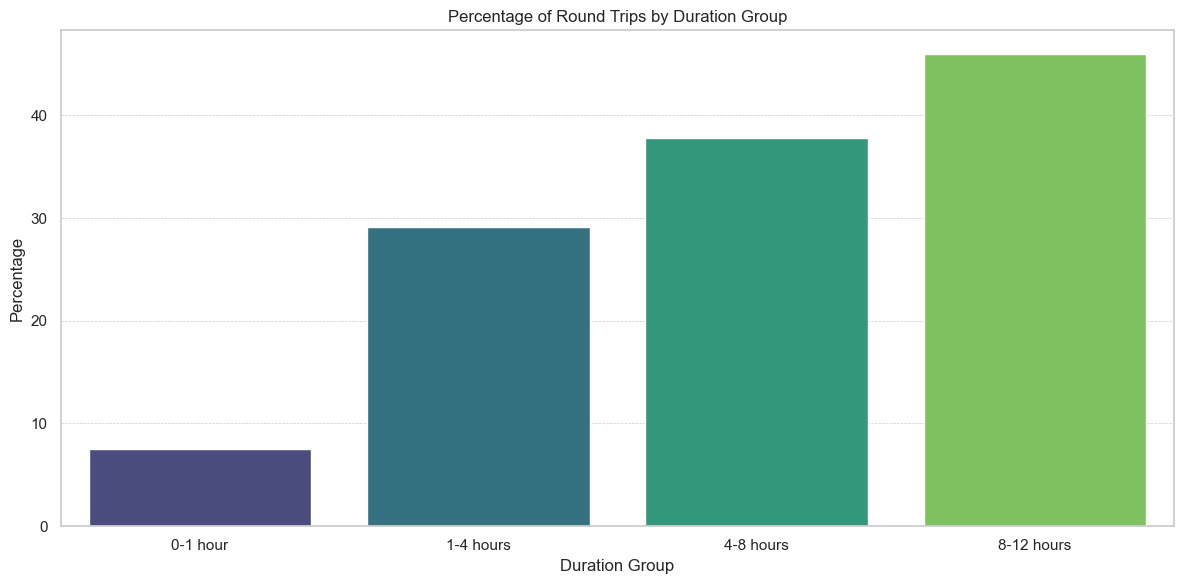

In [59]:
# for each duration group calculate percentage of round trips(which is a bool column)
roundtrip_percentages = []
for label in labels:
    roundtrip_percentage = (rentals[rentals['DurationGroup'] == label]['RoundTrip'].sum() / len(rentals[rentals['DurationGroup'] == label])) * 100
    roundtrip_percentages.append(roundtrip_percentage)
    print(f"Percentage of round trips for {label}: {roundtrip_percentage:.2f}%")

# plod the roundtrip_percentages in the best chart
plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=roundtrip_percentages, palette='viridis')
plt.title('Percentage of Round Trips by Duration Group')
plt.xlabel('Duration Group')
plt.ylabel('Percentage')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


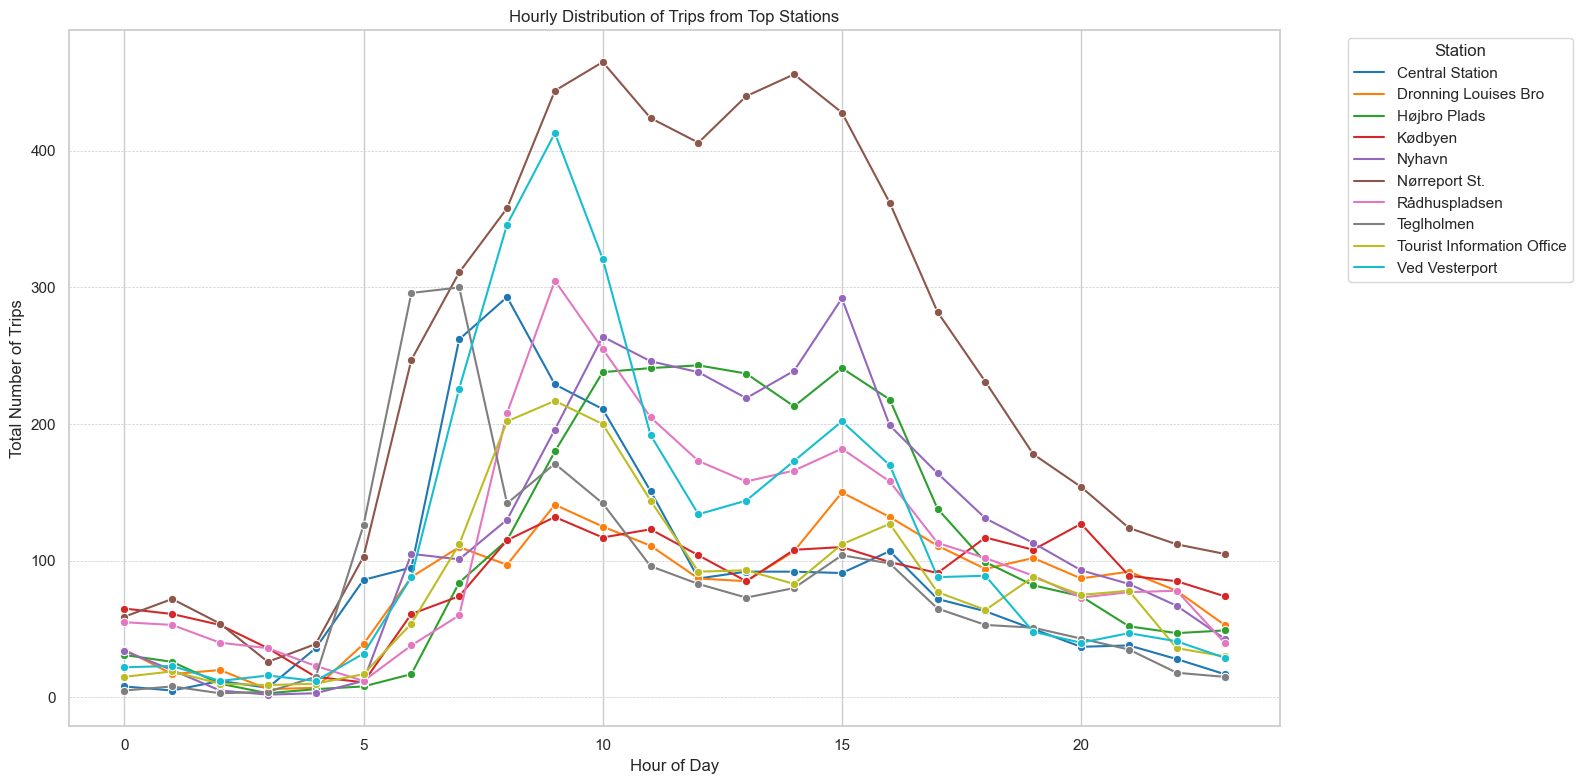

In [86]:
# Analyzing the hourly distribution of trips from the top stations
hourly_distribution = rentals[rentals['StartClusterName'].isin(top_start_hubs.index)]
hourly_distribution = hourly_distribution.groupby(['StartClusterName', 'StartHour']).size().reset_index(name='TripCount')

# Plotting the hourly distribution for top stations
plt.figure(figsize=(16, 8))
sns.lineplot(data=hourly_distribution, x='StartHour', y='TripCount', hue='StartClusterName', marker="o", palette="tab10")
plt.title('Hourly Distribution of Trips from Top Stations')
plt.xlabel('Hour of Day')
plt.ylabel('Total Number of Trips')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend(title='Station', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [87]:
hourly_distribution

,StartClusterName,StartHour,TripCount
0,Central Station,0,8
1,Central Station,1,5
2,Central Station,2,12
3,Central Station,3,7
4,Central Station,4,36
...,...,...,...
235,Ved Vesterport,19,48
236,Ved Vesterport,20,40
237,Ved Vesterport,21,47
238,Ved Vesterport,22,41


In [63]:
# calculate haversine distance between Israeli Plads Ii and Norreport St. (the two most popular stations) in nameStart
station1 = (55.683292, 12.569537)
station2 = (55.682597, 12.571227)
haversine(station1, station2, unit="m")


131.1349926824922

In [64]:
rentals.columns

Index(['StartTime', 'EndTime', 'UserId', 'latitudeStart', 'longitudeStart',
       'nameStart', 'latitudeEnd', 'longitudeEnd', 'nameEnd',
       'StartHubClusterId', 'EndHubClusterId', 'StartClusterName',
       'EndClusterName', 'StartClusterLatitude', 'StartClusterLongitude',
       'EndClusterLatitude', 'EndClusterLongitude', 'HaversineDistance',
       'Month', 'StartHour', 'Weekday', 'TripDurationMin', 'TripDurationHr',
       'SpeedKmHr', 'RoundTrip', 'Route', 'YearMonth', 'DurationGroup'],
      dtype='object')

# Accessibility 


This section is dedicated to the analysis of the accessibility of the bike sharing system. We'll answer questions like:
 - How would the same trip look like if we were to use public transport?
 - How many people can access the bike sharing system within a given time?


# Accessibility Research Questions: Bike Trips vs. Public Transport

1. **Proximity and Mode Choice**: How does the closeness to bike-sharing stations versus public transport stops influence individuals' transportation choices?
2. **Total Trip Time Comparison**: What are the differences in total trip time, including walking and waiting times, when using bike-sharing versus public transport for typical urban journeys?
3. **Transfers and Time Penalties**: How do the number of transfers and related time costs compare between bike-sharing and public transport routes?
4. **Door-to-Door Travel Time**: How does door-to-door travel time vary between bike-sharing and public transport across different trip distances?
5. **Socio-Economic Accessibility**: How does accessibility to bike-sharing and public transport vary among different socio-economic groups and districts?
6. **Last-Mile Connectivity**: What impact does bike-sharing have on public transport use for completing the final segment of a journey?
7. **Influence of Weather Conditions**: How do weather conditions impact the choice between bike-sharing and public transport?
8. **Health Implications**: What are the health benefits and risks of choosing bike-sharing over public transport for regular commutes?
9. **Infrastructure's Role in Modal Choice**: How does the presence and quality of infrastructure, such as bike lanes and public transport frequency, influence the choice of transport mode?
10. **Integration for Efficiency**: Can the integration of bike-sharing data with public transport systems enhance overall travel efficiency and accessibility for city dwellers?


In [66]:
# get rentals with oneway trips which are short in duration
short_oneway_trips = rentals[(rentals['RoundTrip'] == False) & (rentals['TripDurationHr'] <= 2)]
# reset index
short_oneway_trips.reset_index(drop=True, inplace=True)

In [67]:
short_oneway_trips.head()

,StartTime,EndTime,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd,StartHubClusterId,EndHubClusterId,StartClusterName,EndClusterName,StartClusterLatitude,StartClusterLongitude,EndClusterLatitude,EndClusterLongitude,HaversineDistance,Month,StartHour,Weekday,TripDurationMin,TripDurationHr,SpeedKmHr,RoundTrip,Route,YearMonth,DurationGroup
0,2018-03-01 17:43:14.707445,2018-03-01 18:14:12.145000,108186,55.673440,12.564409,Central Station,55.658239,12.605434,Skotlands Plads,590,331,Central Station,Skotlands Plads,55.673117,12.564212,55.658397,12.605787,3.078446,March,17,Thursday,30.957293,0.515955,6.008277,False,Central Station -> Skotlands Plads,2018-03,0-1 hour
1,2018-03-03 13:22:27.557683,2018-03-03 13:40:09.817000,109897,55.673668,12.571551,H. C. Andersens Blvd.,55.668555,12.547020,Broagergade,579,564,Ved Glyptoteket,Broagergade,55.672956,12.570784,55.669073,12.546464,1.640003,March,13,Saturday,17.704322,0.295072,10.505909,False,Ved Glyptoteket -> Broagergade,2018-03,0-1 hour
2,2018-03-05 19:36:10.465740,2018-03-05 20:08:05.639261,85556,55.660674,12.562797,Skibbroen,55.662863,12.561555,Cykelslangen,547,548,Skibbroen,Cykelslangen,55.660833,12.562628,55.662798,12.562180,0.255500,March,19,Monday,31.919559,0.531993,5.827148,False,Skibbroen -> Cykelslangen,2018-03,0-1 hour
3,2018-03-06 07:45:32.192047,2018-03-06 08:09:27.571000,1,55.672142,12.590571,Christianshavn,55.665808,12.578714,Egilsgade,50,542,Christianshavn,Egilsgade,55.672121,12.590597,55.665262,12.579198,1.024221,March,7,Tuesday,23.922983,0.398716,7.774950,False,Christianshavn -> Egilsgade,2018-03,0-1 hour
4,2018-03-06 11:08:30.367733,2018-03-06 12:45:54.777422,114317,55.664807,12.604102,Jemtelandsgade,55.672142,12.590571,Christianshavn,325,50,Jemtelandsgade,Christianshavn,55.664842,12.604332,55.672121,12.590598,1.176984,March,11,Tuesday,97.406828,1.623447,1.909517,False,Jemtelandsgade -> Christianshavn,2018-03,1-4 hours


In [68]:
# create dictionary of weekday and the dates for last week with weekday name being key, and date being value
last_week = {}
for i in range(7):
    date = dt.today().date() - pd.Timedelta(days=i)
    last_week[date.strftime('%A')] = date

last_week


{'Tuesday': datetime.date(2023, 11, 21),
 'Monday': datetime.date(2023, 11, 20),
 'Sunday': datetime.date(2023, 11, 19),
 'Saturday': datetime.date(2023, 11, 18),
 'Friday': datetime.date(2023, 11, 17),
 'Thursday': datetime.date(2023, 11, 16),
 'Wednesday': datetime.date(2023, 11, 15)}

In [69]:
def update_start_date_vectorized(weekdays, start_dates, last_week_dates):
    """
    Vectorized function to update the 'StartDate' based on the 'Weekday' column.

    :param weekdays: Series of weekdays from the dataframe.
    :param start_dates: Series of start dates from the dataframe.
    :param last_week_dates: Dictionary mapping weekdays to their last occurrence dates.
    :return: Series of updated start dates with the time from the original 'StartDate'.
    """
    # Find the dates for the last occurrences of the weekdays
    update_dates = weekdays.map(last_week_dates)
    # Extract the time from the start_dates
    times = start_dates.dt.time
    # Combine the last occurrence dates with the corresponding times
    updated_dates = np.vectorize(dt.combine)(update_dates, times)
    
    return updated_dates

C:\Users\mihai\AppData\Local\Temp\ipykernel_21340\2164217464.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Assuming df is your dataframe and it contains 'Weekday' and 'StartDate' columns
# You would use the function as follows:
short_oneway_trips.loc[:, 'StartTimeUpdated'] = update_start_date_vectorized(short_oneway_trips['Weekday'], short_oneway_trips['StartTime'], last_week)

In [70]:
import requests

def get_top_itineraries(from_lat, from_lon, to_lat, to_lon, datetime_obj, 
                        mode ='TRANSIT', arrive_by=False, wheelchair=False, 
                        show_intermediate_stops=True, locale='en', num_itineraries=3):
    
    # Format the date and time
    date = datetime_obj.strftime('%Y-%m-%d')  # Format: YYYY-MM-DD
    time = datetime_obj.strftime('%H:%M')     # Format: HH:MM (24-hour)

    # Construct the URL with query parameters
    url = (
        'http://localhost:8080/otp/routers/default/plan'
        '?fromPlace={},{}'
        '&toPlace={},{}'
        '&time={}'
        '&date={}'
        '&mode={}'
        '&arriveBy={}'
        '&wheelchair={}'
        '&showIntermediateStops={}'
        '&locale={}'
        '&numItineraries={}'
        '&optimize=QUICK'  # Ensure the fastest route is prioritized
    ).format(
        from_lat, from_lon, 
        to_lat, to_lon, 
        time, 
        date, 
        mode, 
        str(arrive_by).lower(), 
        str(wheelchair).lower(), 
        str(show_intermediate_stops).lower(), 
        locale,
        num_itineraries)
    # Send the request
    response = requests.get(url)
    return response.json()

#result = get_top_itineraries(55.69476, 12.54042, 55.75405, 12.30457, datetime.datetime(2023, 11, 11, 14, 16))


In [71]:
'''import pandas as pd
import numpy as np
# Redefining the function to process the JSON response directly and extract numeric values.

def fetch_and_process_fastest_itinerary_direct(response):
    try:
        # Extract the itineraries directly from the response
        itineraries = response['plan']['itineraries']
        
        # Find the fastest itinerary based on total duration
        fastest_itinerary = min(itineraries, key=lambda x: x['duration'])
        
        # Initialize values
        total_walking_time = 0
        total_transit_time = 0
        changes = -1  # Start at -1 to account for the initial leg not being a change
        previous_mode = None
        distance_to_station = np.nan

        # Process each leg in the fastest itinerary
        for leg in fastest_itinerary['legs']:
            # Calculate walking time in minutes
            if leg['mode'] == "WALK":
                total_walking_time += leg['duration'] / 60.0  # Convert seconds to minutes
                if distance_to_station is np.nan:  # Only set for the first walking step
                    distance_to_station = leg['distance']  # Distance in meters

            # Calculate transit time in minutes for other modes
            else:
                total_transit_time += leg['duration'] / 60.0  # Convert seconds to minutes
            
            # Count the number of changes
            if previous_mode and leg['mode'] != previous_mode and leg['mode'] != "WALK":
                changes += 1
            previous_mode = leg['mode']

        # If there were no changes, set changes to 0
        changes = max(changes, 0)

        # Convert distance from meters to kilometers for total distance
        total_distance = sum(leg["distance"] for leg in fastest_itinerary["legs"]) / 1000  # distance in km

        # Construct the details dictionary with the calculated values
        details = {
            "TotalDurationMin": fastest_itinerary['duration'] / 60.0,
            "TripDistanceKm": total_distance,
            "TotalWalkingTimeMin": total_walking_time,
            "TotalTransitTimeMin": total_transit_time,
            "Changes": changes,
            "DistanceToStationMeters": distance_to_station if not np.isnan(distance_to_station) else 0
        }
        return details
    except Exception as e:
        print(f"Error processing itinerary: {e}")
        # Return a series of NaN values if there's an error
        return {
            "TotalDurationMin": np.nan,
            "TripDistanceKm": np.nan,
            "TotalWalkingTimeMin": np.nan,
            "TotalTransitTimeMin": np.nan,
            "Changes": np.nan,
            "DistanceToStationMeters": np.nan
        }

# Process the JSON response directly to get the fastest itinerary details
fastest_itinerary_direct = fetch_and_process_fastest_itinerary_direct(result)
fastest_itinerary_direct'''


'import pandas as pd\nimport numpy as np\n# Redefining the function to process the JSON response directly and extract numeric values.\n\ndef fetch_and_process_fastest_itinerary_direct(response):\n    try:\n        # Extract the itineraries directly from the response\n        itineraries = response[\'plan\'][\'itineraries\']\n        \n        # Find the fastest itinerary based on total duration\n        fastest_itinerary = min(itineraries, key=lambda x: x[\'duration\'])\n        \n        # Initialize values\n        total_walking_time = 0\n        total_transit_time = 0\n        changes = -1  # Start at -1 to account for the initial leg not being a change\n        previous_mode = None\n        distance_to_station = np.nan\n\n        # Process each leg in the fastest itinerary\n        for leg in fastest_itinerary[\'legs\']:\n            # Calculate walking time in minutes\n            if leg[\'mode\'] == "WALK":\n                total_walking_time += leg[\'duration\'] / 60.0  # Conver

In [72]:
def fetch_and_process_fastest_itinerary(response):
    try:
        # Extract itineraries and find the fastest one
        itineraries = response['plan']['itineraries']
        fastest_itinerary = min(itineraries, key=lambda x: x['duration'])
        
        # Use list comprehensions to calculate walking and transit times, and distances
        walking_legs = [leg for leg in fastest_itinerary['legs'] if leg['mode'] == "WALK"]
        transit_legs = [leg for leg in fastest_itinerary['legs'] if leg['mode'] != "WALK"]

        total_walking_time = sum(leg['duration'] for leg in walking_legs) / 60.0
        total_transit_time = sum(leg['duration'] for leg in transit_legs) / 60.0
        total_distance = sum(leg['distance'] for leg in fastest_itinerary['legs']) / 1000
        
        # Get the first walking leg's distance if it exists
        distance_to_station = walking_legs[0]['distance'] if walking_legs else np.nan
        # get the last walking leg's distance if it exists
        distance_to_destination = walking_legs[-1]['distance'] if walking_legs else np.nan

        # Calculate changes by comparing modes between subsequent legs (ignoring 'WALK' legs)
        modes = [leg['mode'] for leg in transit_legs]
        changes = sum(m1 != m2 for m1, m2 in zip(modes, modes[1:]))

        # Construct the details dictionary
        details = {
            "TotalDurationMin": fastest_itinerary['duration'] / 60.0,
            "TripDistanceKm": total_distance,
            "TotalWalkingTimeMin": total_walking_time,
            "TotalTransitTimeMin": total_transit_time,
            "Changes": changes,
            'PickupStationProximity': distance_to_station if not np.isnan(distance_to_station) else 0,
            "DropoffStationProximity": distance_to_destination if not np.isnan(distance_to_destination) else 0
        }
        return details
    except KeyError as e:
        print(f"Error processing itinerary: {e}")
        # Return NaN values if there's an error in the response format
        return {
            "TotalDurationMin": np.nan,
            "TripDistanceKm": np.nan,
            "TotalWalkingTimeMin": np.nan,
            "TotalTransitTimeMin": np.nan,
            "Changes": np.nan,
            'PickupStationProximity': np.nan,
            "DropoffStationProximity": np.nan
        }
#fastest_itinerary = fetch_and_process_fastest_itinerary(result)
#fastest_itinerary

In [73]:

'''def fetch_and_process_itinerary(row, num_itineraries):
    response = get_top_itineraries(
            row['StartClusterLatitude'], row['StartClusterLongitude'],
            row['EndClusterLatitude'], row['EndClusterLongitude'],
            row['StartTimeUpdated'],
            num_itineraries=num_itineraries
        )
    itinerary_info = fetch_and_process_fastest_itinerary(response)
    #print(itinerary_info)
    return pd.Series(itinerary_info)

# Use swifter to apply the function to the DataFrame.
# Swifter automatically manages progress and will use dask to parallelize if necessary.
# However, if you specifically want to use tqdm, you can apply tqdm to the DataFrame before swifter.
tqdm.pandas(desc="Processing itineraries")
short_oneway_trips[['TotalDurationMin', 'TripDistanceKm', 'TotalWalkingTimeMin', 'TotalTransitTimeMin', 'Changes', "DistanceToStationMeters"]] = \
    short_oneway_trips.swifter.progress_bar(enable=True).apply(
        lambda row: fetch_and_process_itinerary(row, num_itineraries=3), axis=1)

# Swifter's progress bar is enabled by default, so the above line will show progress.
# Now 'one_way_trips' DataFrame has the new columns with the itinerary information.
'''

'def fetch_and_process_itinerary(row, num_itineraries):\n    response = get_top_itineraries(\n            row[\'StartClusterLatitude\'], row[\'StartClusterLongitude\'],\n            row[\'EndClusterLatitude\'], row[\'EndClusterLongitude\'],\n            row[\'StartTimeUpdated\'],\n            num_itineraries=num_itineraries\n        )\n    itinerary_info = fetch_and_process_fastest_itinerary(response)\n    #print(itinerary_info)\n    return pd.Series(itinerary_info)\n\n# Use swifter to apply the function to the DataFrame.\n# Swifter automatically manages progress and will use dask to parallelize if necessary.\n# However, if you specifically want to use tqdm, you can apply tqdm to the DataFrame before swifter.\ntqdm.pandas(desc="Processing itineraries")\nshort_oneway_trips[[\'TotalDurationMin\', \'TripDistanceKm\', \'TotalWalkingTimeMin\', \'TotalTransitTimeMin\', \'Changes\', "DistanceToStationMeters"]] =     short_oneway_trips.swifter.progress_bar(enable=True).apply(\n        lambda r

In [74]:
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# This function is a wrapper around the 'fetch_and_process_fastest_itinerary' for concurrent processing
'''def fetch_and_process_itinerary_concurrent(start_lat, start_lon, end_lat, end_lon, start_time, num_itineraries):
    response = get_top_itineraries(start_lat, start_lon, end_lat, end_lon, start_time, num_itineraries=num_itineraries)
    return fetch_and_process_fastest_itinerary(response)

# The main function to process the DataFrame concurrently and update the results
def main_concurrent(df, num_itineraries):
    # Temporary dictionary to hold the results
    results = {}
    with ThreadPoolExecutor(max_workers=50) as executor:
        # Prepare and submit all futures
        futures_to_index = {
            executor.submit(
                fetch_and_process_itinerary_concurrent,
                row['StartClusterLatitude'], row['StartClusterLongitude'],
                row['EndClusterLatitude'], row['EndClusterLongitude'],
                row['StartTimeUpdated'],
                num_itineraries
            ): index for index, row in df.iterrows()
        }
        
        # Process futures as they complete and show progress
        for future in tqdm(as_completed(futures_to_index), total=len(futures_to_index), desc="Processing itineraries"):
            index = futures_to_index[future]
            try:
                results[index] = future.result()
            except Exception as exc:
                print(f'Row {index} generated an exception: {exc}')
                results[index] = {
                    "TotalDurationMin": np.nan,
                    "TripDistanceKm": np.nan,
                    "TotalWalkingTimeMin": np.nan,
                    "TotalTransitTimeMin": np.nan,
                    "Changes": np.nan,
                    'PickupStationProximity': np.nan,
                    "DropoffStationProximity": np.nan
                }
    
    # Update the DataFrame outside the thread pool
    for index, data in results.items():
        for key, value in data.items():
            df.at[index, key] = value

# Call the main function with the dataframe and the number of itineraries
'''


In [75]:
main_concurrent(short_oneway_trips, num_itineraries=3)

Processing itineraries: 100%|██████████| 99265/99265 [2:24:26<00:00, 11.45it/s]  
C:\Users\mihai\AppData\Local\Temp\ipykernel_21340\2164290158.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mihai\AppData\Local\Temp\ipykernel_21340\2164290158.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\mihai\AppData\Local\Temp\ipykernel_21340\2164290158.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [76]:
short_oneway_trips.UserId.value_counts()

UserId
260555    266
197608    233
139464    227
113741    215
195931    182
         ... 
302618      1
302650      1
165678      1
302705      1
337417      1
Name: count, Length: 25109, dtype: int64

In [79]:
short_oneway_trips[['TotalDurationMin', 'TripDistanceKm', 'TotalWalkingTimeMin', 'TotalTransitTimeMin', 'Changes', 'PickupStationProximity', "DropoffStationProximity"]].describe()

,TotalDurationMin,TripDistanceKm,TotalWalkingTimeMin,TotalTransitTimeMin,Changes,PickupStationProximity,DropoffStationProximity
count,99265.000000,99265.000000,99265.000000,99265.000000,99265.000000,99265.000000,99265.000000
mean,21.073947,3.630448,12.637923,7.573337,0.113585,454.800443,435.817953
std,8.425901,2.238740,5.947029,5.891252,0.330922,366.148411,361.764654
min,1.733333,0.128850,0.216667,0.000000,0.000000,0.710000,0.410000
25%,15.133333,2.012070,8.050000,3.000000,0.000000,170.330000,158.730000
50%,20.716667,3.258760,12.316667,7.000000,0.000000,365.760000,341.520000
75%,26.400000,4.819740,16.566667,11.000000,0.000000,639.310000,607.980000
max,72.016667,22.544580,48.166667,43.000000,3.000000,3659.270000,3659.270000


In [80]:
short_oneway_trips['Changes'].value_counts()

Changes
0.0    88427
1.0    10402
2.0      435
3.0        1
Name: count, dtype: int64

In [81]:
short_oneway_trips.head()

,StartTime,EndTime,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd,StartHubClusterId,EndHubClusterId,StartClusterName,EndClusterName,StartClusterLatitude,StartClusterLongitude,EndClusterLatitude,EndClusterLongitude,HaversineDistance,Month,StartHour,Weekday,TripDurationMin,TripDurationHr,SpeedKmHr,RoundTrip,Route,YearMonth,DurationGroup,StartTimeUpdated,TotalDurationMin,TripDistanceKm,TotalWalkingTimeMin,TotalTransitTimeMin,Changes,PickupStationProximity,DropoffStationProximity
0,2018-03-01 17:43:14.707445,2018-03-01 18:14:12.145000,108186,55.673440,12.564409,Central Station,55.658239,12.605434,Skotlands Plads,590,331,Central Station,Skotlands Plads,55.673117,12.564212,55.658397,12.605787,3.078446,March,17,Thursday,30.957293,0.515955,6.008277,False,Central Station -> Skotlands Plads,2018-03,0-1 hour,2023-11-16 17:43:14.707445,17.500000,3.86560,6.500000,11.0,0.0,324.78,125.35
1,2018-03-03 13:22:27.557683,2018-03-03 13:40:09.817000,109897,55.673668,12.571551,H. C. Andersens Blvd.,55.668555,12.547020,Broagergade,579,564,Ved Glyptoteket,Broagergade,55.672956,12.570784,55.669073,12.546464,1.640003,March,13,Saturday,17.704322,0.295072,10.505909,False,Ved Glyptoteket -> Broagergade,2018-03,0-1 hour,2023-11-18 13:22:27.557683,15.533333,2.69815,10.533333,5.0,0.0,80.07,677.63
2,2018-03-05 19:36:10.465740,2018-03-05 20:08:05.639261,85556,55.660674,12.562797,Skibbroen,55.662863,12.561555,Cykelslangen,547,548,Skibbroen,Cykelslangen,55.660833,12.562628,55.662798,12.562180,0.255500,March,19,Monday,31.919559,0.531993,5.827148,False,Skibbroen -> Cykelslangen,2018-03,0-1 hour,2023-11-20 19:36:10.465740,7.900000,0.50468,7.900000,0.0,0.0,504.68,504.68
3,2018-03-06 07:45:32.192047,2018-03-06 08:09:27.571000,1,55.672142,12.590571,Christianshavn,55.665808,12.578714,Egilsgade,50,542,Christianshavn,Egilsgade,55.672121,12.590597,55.665262,12.579198,1.024221,March,7,Tuesday,23.922983,0.398716,7.774950,False,Christianshavn -> Egilsgade,2018-03,0-1 hour,2023-11-21 07:45:32.192047,15.233333,1.87281,14.233333,1.0,0.0,100.86,538.09
4,2018-03-06 11:08:30.367733,2018-03-06 12:45:54.777422,114317,55.664807,12.604102,Jemtelandsgade,55.672142,12.590571,Christianshavn,325,50,Jemtelandsgade,Christianshavn,55.664842,12.604332,55.672121,12.590598,1.176984,March,11,Tuesday,97.406828,1.623447,1.909517,False,Jemtelandsgade -> Christianshavn,2018-03,1-4 hours,2023-11-21 11:08:30.367733,7.666667,1.49165,1.666667,6.0,0.0,30.46,68.54


In [82]:
# save the dataframe to a csv file
#short_oneway_trips.to_csv('../data/processed/short_oneway_trips.csv', index=False)